/Users/beckynevin/anaconda3/lib/python3.7/site-packages/marvin/extern/marvin_brain/python/brain/__init__.py:97: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(open(os.path.join(os.path.dirname(__file__), 'data/brain.yml')))
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/marvin/__init__.py:128: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/marvin/extern/tree/python/tree/__init__.py:21: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(ff)


INFO: No release version set. Setting default to MPL-8


/Users/beckynevin/anaconda3/lib/python3.7/site-packages/marvin/extern/sdss_access/python/sdss_access/__init__.py:31: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(ff)
/Users/beckynevin/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/beckynevin/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/beckynevin/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/beckynevin/

Access is public
SDSS_ACCESS> syncing... please wait
SDSS_ACCESS> Done!


/Users/beckynevin/anaconda3/lib/python3.7/site-packages/marvin/tools/maps.py:213: ResourceWarning: unclosed file <_io.TextIOWrapper name='/tmp/sdss_access/20191115_001/sdss_access_00.err' mode='w' encoding='UTF-8'>
  return super(Maps, self).download(path_type, **params)


<Figure size 432x288 with 0 Axes>

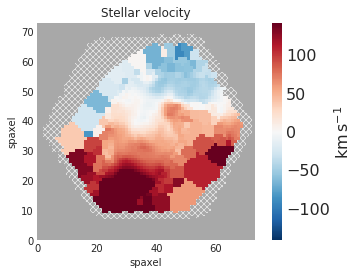

In [1]:
# Step 1: Get Marvin up and running
# Marvin is a tool from MaNGA, read how to install it here - https://github.com/sdss/marvin


# For this tutorial, there are a couple of different options you are either a collaborator 
# or a member of the public.
# If you are a SDSS-IV collaborator make sure you have collaborator access using these instructions:
# https://sdss-marvin.readthedocs.io/en/stable/installation.html
# If you are not a SDSS-IV collaborator, proceed using the config.access = 'public' key below.

 
import matplotlib.pyplot as plt
import numpy as np
import marvin
from marvin import config, marvindb
# Again, if this doesn't work, go read these instructions on setting it up - https://github.com/sdss/marvin
from marvin.tools.maps import Maps
import pyfits
import os
from marvin.tools.query import Query
from sh import gunzip
from marvin.utils.general import downloadList
import random
import re


%matplotlib inline

config.access = 'public'#'collab' if collab
# Option to choose the data release you would like to use:
#config.setRelease('MPL-6')
print('Access is',config.access)

# I had to re-log in when I first ran this code, so if you're a collab you can use this to do so:
if config.access =='collab':
    config.login(refresh=True)
    print(config.token)



# Check to see if this map loads remotely, if so you are good to go- 
plateids = ['7443-12703']# this is my favorite galaxy
Maps(plateids[0]).download()

maps = [Maps(plateid) for plateid in plateids]
# maps.datamodel shows all the options for various map extensions
# ie:
# print(Maps('7443-12703').datamodel)

svel_maps = [mapz['stellar_vel'] for mapz in maps]# this is in case you want to feed it a list
svel_map = svel_maps[0]

plt.clf()
fig, ax = svel_map.plot()
plt.show()

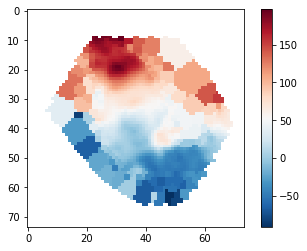

In [2]:
# this is how to directly retrieve the stellar velocity map - use svel_map.value

plt.clf()
plt.imshow(np.ma.masked_where(svel_map.value==0, svel_map.value), cmap='RdBu_r')
plt.colorbar()
plt.show()

# By the way, this is my favorite galaxy in MaNGA, it's a stunning merger.

In [10]:
# The first step is to acquire a bunch of stellar velocity maps - selected somewhat randomly from various galaxies.
# One way to get a bunch of maps is through the dapall file 
# Another way is to use the Marvin Query tool (I was having problems with this because it is limited in the number
# of galaxies you can select)
# this is useful: https://sdss-marvin.readthedocs.io/en/stable/tools/catalogues.html



dapall = pyfits.open('dapall-v2_5_3-2.3.0.fits')# apparently, this is DR15, and is therefore publicly available

# There is a lot of info in this file:
#print(dapall[0].header)

# Select all of the plateifu identifiers that are available in this MaNGA release
all_plateifus = dapall[1].data['PLATEIFU']
print('Length of different plateifus', len(all_plateifus))# there are a lot of galaxies, some of these must be repeats

# Create a randomized list of plateifus, so that they are not in any specific order:

# Select 100 random plateifus
sampling = random.sample(list(all_plateifus), k=100)
print("sampling with choices", len(sampling),sampling)

# Check if there are any repeats here - 

def checkIfDuplicates_1(listOfElems):
    ''' Check if given list contains any duplicates '''
    if len(listOfElems) == len(set(listOfElems)):
        return False
    else:
        return True

result = checkIfDuplicates_1(sampling)
 
if result:
    print('Yes, list contains duplicates')
else:
    print('No duplicates found in list')   



# I'm having this problem where the downloading of files hangs for some of the plateifus in the dapall file.
# I found that these are the ones that have a bunch of errors (values ==-9999) in the dapall, so I just cut these
# from the list and continue.
# Therefore, the purpose of the next section is to only select galaxies that are okay in the dapall file:
print(dapall[1].header)

new_sampling=[]
for j in range(len(sampling)):
    for k in range(len(dapall[1].data)):
        #print(dapall[1].data[k])
        #STOP
        if dapall[1].data['PLATEIFU'][k]==sampling[j]:
            #if dapall[1].data[k][-1][-1]==-9999.:
                #print('999999999')
                #continue
            #else:
            new_sampling.append(sampling[j])
            #print(drpall[1].data[k])
            

print("sampling after cuts", len(new_sampling),new_sampling)


# Now it is time to download the galaxies locally, I've found this is much faster
# than calling them remotely all the time:
# Create a folder on your machine, if you are following the SDSS/MaNGA framework, you can
# put everything in a place called sas in your home directory.
# I'm using the Voronoi binned files, so that's why I reference that file structure below.

download_plateifu_list=[]
# I've written this code to first check what is already there and unzip it:
for j in range(len(new_sampling)):
    fn = '/Users/beckynevin/sas/mangawork/manga/spectro/analysis/v2_5_3/2.3.0/VOR10-MILESHC-MILESHC/'+str(new_sampling[j][:4])+'/'+str(new_sampling[j][5:])+'/manga-'+str(new_sampling[j])+'-MAPS-VOR10-MILESHC-MILESHC.fits.gz'
    
    if os.path.isfile(fn):
        # If the .gz file is there, then you should unzip it
        gunzip(fn)
    else:
        continue
        
# The next step is to try to open each .fits file and if it is not there, you need to go download it:
for j in range(len(new_sampling)):
    
    try:
        pyfits.open('/Users/beckynevin/sas/mangawork/manga/spectro/analysis/v2_5_3/2.3.0/VOR10-MILESHC-MILESHC/'+str(new_sampling[j][:4])+'/'+str(new_sampling[j][5:])+'/manga-'+str(new_sampling[j])+'-MAPS-VOR10-MILESHC-MILESHC.fits')
    except FileNotFoundError:
        # This means you actually have to download it
        download_plateifu_list.append(new_sampling[j])
        
print('DOWNLOAD THESE', len(download_plateifu_list), download_plateifu_list)



# Download all the maps you need
downloadList(download_plateifu_list,dltype='maps', bintype='VOR10')

# And then unzip them :)
for j in range(len(download_plateifu_list)):
    fn = '/Users/beckynevin/sas/mangawork/manga/spectro/analysis/v2_5_3/2.3.0/VOR10-MILESHC-MILESHC/'+str(download_plateifu_list[j][:4])+'/'+str(download_plateifu_list[j][5:])+'/manga-'+str(download_plateifu_list[j])+'-MAPS-VOR10-MILESHC-MILESHC.fits.gz'
    #print(fn)
    if os.path.isfile(fn):
        # Then you should unzip it
        gunzip(fn)
    else:
        continue

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: ResourceWarning: unclosed file <_io.FileIO name='dapall-v2_5_3-2.3.0.fits' mode='rb' closefd=True>
  if __name__ == '__main__':


Length of different plateifus 19596
sampling with choices 100 ['8097-9102', '8131-12701', '8989-3702', '7495-12704', '8979-1901', '8931-3703', '10517-3701', '8077-3704', '9501-3701', '9042-3703', '9886-6103', '8257-3703', '8464-3704', '8082-12703', '7962-3704', '8944-1902', '9487-6101', '8726-1901', '8450-6101', '8309-9102', '8250-1901', '9190-3702', '8443-6102', '8547-12702', '9875-6101', '8931-9102', '9508-3703', '8714-3703', '9510-3702', '10514-6102', '8948-3704', '8606-12701', '8486-12704', '9038-1902', '8481-3703', '9042-1902', '9032-9101', '8258-6103', '8553-6104', '9511-3701', '8999-9101', '9871-12705', '8244-12704', '8618-6104', '9087-1902', '8938-3704', '8604-1901', '8721-12703', '8150-12703', '8453-3701', '8082-1901', '8713-12702', '8320-3703', '8440-12703', '8979-12701', '9495-6101', '8132-3701', '8336-3701', '9086-9101', '9088-1902', '9039-12701', '8985-6103', '8611-6103', '8250-6101', '8482-6104', '9508-12704', '7977-6104', '9183-3704', '8600-12705', '8719-12702', '9494-19

sampling after cuts 300 ['8097-9102', '8097-9102', '8097-9102', '8131-12701', '8131-12701', '8131-12701', '8989-3702', '8989-3702', '8989-3702', '7495-12704', '7495-12704', '7495-12704', '8979-1901', '8979-1901', '8979-1901', '8931-3703', '8931-3703', '8931-3703', '10517-3701', '10517-3701', '10517-3701', '8077-3704', '8077-3704', '8077-3704', '9501-3701', '9501-3701', '9501-3701', '9042-3703', '9042-3703', '9042-3703', '9886-6103', '9886-6103', '9886-6103', '8257-3703', '8257-3703', '8257-3703', '8464-3704', '8464-3704', '8464-3704', '8082-12703', '8082-12703', '8082-12703', '7962-3704', '7962-3704', '7962-3704', '8944-1902', '8944-1902', '8944-1902', '9487-6101', '9487-6101', '9487-6101', '8726-1901', '8726-1901', '8726-1901', '8450-6101', '8450-6101', '8450-6101', '8309-9102', '8309-9102', '8309-9102', '8250-1901', '8250-1901', '8250-1901', '9190-3702', '9190-3702', '9190-3702', '8443-6102', '8443-6102', '8443-6102', '8547-12702', '8547-12702', '8547-12702', '9875-6101', '9875-6101'

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:86: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/sas/mangawork/manga/spectro/analysis/v2_5_3/2.3.0/VOR10-MILESHC-MILESHC/7495/12704/manga-7495-12704-MAPS-VOR10-MILESHC-MILESHC.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:86: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/sas/mangawork/manga/spectro/analysis/v2_5_3/2.3.0/VOR10-MILESHC-MILESHC/8450/6101/manga-8450-6101-MAPS-VOR10-MILESHC-MILESHC.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:86: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/sas/mangawork/manga/spectro/analysis/v2_5_3/2.3.0/VOR10-MILESHC-MILESHC/8443/6102/manga-8443-6102-MAPS-VOR10-MILESHC-MILESHC.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:86: Reso

DOWNLOAD THESE 270 ['8097-9102', '8097-9102', '8097-9102', '8131-12701', '8131-12701', '8131-12701', '8989-3702', '8989-3702', '8989-3702', '8979-1901', '8979-1901', '8979-1901', '8931-3703', '8931-3703', '8931-3703', '10517-3701', '10517-3701', '10517-3701', '8077-3704', '8077-3704', '8077-3704', '9501-3701', '9501-3701', '9501-3701', '9042-3703', '9042-3703', '9042-3703', '9886-6103', '9886-6103', '9886-6103', '8257-3703', '8257-3703', '8257-3703', '8464-3704', '8464-3704', '8464-3704', '8082-12703', '8082-12703', '8082-12703', '7962-3704', '7962-3704', '7962-3704', '8944-1902', '8944-1902', '8944-1902', '9487-6101', '9487-6101', '9487-6101', '8726-1901', '8726-1901', '8726-1901', '8309-9102', '8309-9102', '8309-9102', '8250-1901', '8250-1901', '8250-1901', '9190-3702', '9190-3702', '9190-3702', '9875-6101', '9875-6101', '9875-6101', '8931-9102', '8931-9102', '8931-9102', '9508-3703', '9508-3703', '9508-3703', '8714-3703', '8714-3703', '8714-3703', '9510-3702', '9510-3702', '9510-370

MarvinError: Error with sdss_access rsync.set_stream. AccessError: Return code 23
b'rsync: link_stat "manga/spectro/analysis/v2_4_3/2.2.1/*/8097/9102/manga-8097-9102-MAPS-*.fits.gz" (in dr15) failed: No such file or directory (2)\nrsync error: some files could not be transferred (code 23) at /BuildRoot/Library/Caches/com.apple.xbs/Sources/rsync/rsync-52.200.1/rsync/main.c(1404) [receiver=2.6.9]\n'.
You can submit this error to Marvin GitHub Issues (https://github.com/sdss/marvin/issues/new).
Fill out a subject and some text describing the error that just occurred.
If able, copy and paste the full traceback information into the issue as well.

In [11]:
# Query is a powerful tool that can search for galaxies that match various requirements - 

# search for galaxies with an NSA redshift < 0.1 and that have the 'frankenbundle' 127 fiber IFU
# this is a really helpful page on how to design a good filter - 
# https://sdss-marvin.readthedocs.io/en/stable/tutorials/query-examples.html#marvin-query-examples
myfilter = 'nsa.z < 0.1 and ifu.name = 127*'
# this is an elegant way to get all of the same size of maps (they are 74x74) - which is one of the 
# necessary ways to clean the data (present the ML algorithm with only one size of galaxy map)

# create a query
query = Query(search_filter=myfilter, limit=500)
# can make a filter to select a certain subset of galaxies
# you can also set the limit



results = query.run()

#results.download()

#print(results)

#print(results.count)

plateifu_list=[]
for j in range(results.count):
    plateifu_list.append(results.results[j].plateifu)

# make a list of these plateifus, which you will feed to Marvin remotely to get their maps

'''
This is a much longer way to do the same thing - 
for j in range(len(plateifu_list)):
    print(plateifu_list[j])
    try:
        cube = Maps(plateifu_list[j], download=True, bintype='VOR10')
    except:
        print('THIS ONE FAILED', plateifu_list[j])
        
STOP'''

#plateifu_list=['8077-12705']

download_plateifu_list=[]
#How do you check first what is even there?

# First, you need to go through and unzip everything

for j in range(len(plateifu_list)):
    fn = '/Users/beckynevin/sas/mangawork/manga/spectro/analysis/v2_5_3/2.3.0/VOR10-MILESHC-MILESHC/'+str(plateifu_list[j][:4])+'/'+str(plateifu_list[j][5:])+'/manga-'+str(plateifu_list[j])+'-MAPS-VOR10-MILESHC-MILESHC.fits.gz'
    #print(fn)
    if os.path.isfile(fn):
        # Then you should unzip it
        try:
            gunzip(fn)
        except:
            continue
    else:
        continue
        

for j in range(len(plateifu_list)):
    
    try:
        pyfits.open('/Users/beckynevin/sas/mangawork/manga/spectro/analysis/v2_5_3/2.3.0/VOR10-MILESHC-MILESHC/'+str(plateifu_list[j][:4])+'/'+str(plateifu_list[j][5:])+'/manga-'+str(plateifu_list[j])+'-MAPS-VOR10-MILESHC-MILESHC.fits')
    except FileNotFoundError:
        # This means you actually have to download it
        download_plateifu_list.append(plateifu_list[j])
        
print('DOWNLOAD THESE', download_plateifu_list)



downloadList(download_plateifu_list,dltype='maps', bintype='VOR10')

for j in range(len(download_plateifu_list)):
    fn = '/Users/beckynevin/sas/mangawork/manga/spectro/analysis/v2_5_3/2.3.0/VOR10-MILESHC-MILESHC/'+str(download_plateifu_list[j][:4])+'/'+str(download_plateifu_list[j][5:])+'/manga-'+str(download_plateifu_list[j])+'-MAPS-VOR10-MILESHC-MILESHC.fits.gz'
    #print(fn)
    if os.path.isfile(fn):
        # Then you should unzip it
        try:
            gunzip(fn)
        except:
            continue
    else:
        continue

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/marvin/tools/query.py:241: MarvinUserWarning: No local database found. Cannot perform queries.
  warnings.warn('No local database found. Cannot perform queries.', MarvinUserWarning)
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/sas/mangawork/manga/spectro/analysis/v2_5_3/2.3.0/VOR10-MILESHC-MILESHC/8078/12704/manga-8078-12704-MAPS-VOR10-MILESHC-MILESHC.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/sas/mangawork/manga/spectro/analysis/v2_5_3/2.3.0/VOR10-MILESHC-MILESHC/8077/12705/manga-8077-12705-MAPS-VOR10-MILESHC-MILESHC.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/s

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/sas/mangawork/manga/spectro/analysis/v2_5_3/2.3.0/VOR10-MILESHC-MILESHC/8144/12702/manga-8144-12702-MAPS-VOR10-MILESHC-MILESHC.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/sas/mangawork/manga/spectro/analysis/v2_5_3/2.3.0/VOR10-MILESHC-MILESHC/8144/12704/manga-8144-12704-MAPS-VOR10-MILESHC-MILESHC.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/sas/mangawork/manga/spectro/analysis/v2_5_3/2.3.0/VOR10-MILESHC-MILESHC/8139/12701/manga-8139-12701-MAPS-VOR10-MILESHC-MILESHC.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: 

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/sas/mangawork/manga/spectro/analysis/v2_5_3/2.3.0/VOR10-MILESHC-MILESHC/8603/12705/manga-8603-12705-MAPS-VOR10-MILESHC-MILESHC.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/sas/mangawork/manga/spectro/analysis/v2_5_3/2.3.0/VOR10-MILESHC-MILESHC/8603/12703/manga-8603-12703-MAPS-VOR10-MILESHC-MILESHC.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/sas/mangawork/manga/spectro/analysis/v2_5_3/2.3.0/VOR10-MILESHC-MILESHC/9869/12704/manga-9869-12704-MAPS-VOR10-MILESHC-MILESHC.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: 

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/sas/mangawork/manga/spectro/analysis/v2_5_3/2.3.0/VOR10-MILESHC-MILESHC/8937/12703/manga-8937-12703-MAPS-VOR10-MILESHC-MILESHC.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/sas/mangawork/manga/spectro/analysis/v2_5_3/2.3.0/VOR10-MILESHC-MILESHC/8938/12704/manga-8938-12704-MAPS-VOR10-MILESHC-MILESHC.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/sas/mangawork/manga/spectro/analysis/v2_5_3/2.3.0/VOR10-MILESHC-MILESHC/8938/12703/manga-8938-12703-MAPS-VOR10-MILESHC-MILESHC.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: 

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/sas/mangawork/manga/spectro/analysis/v2_5_3/2.3.0/VOR10-MILESHC-MILESHC/8996/12703/manga-8996-12703-MAPS-VOR10-MILESHC-MILESHC.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/sas/mangawork/manga/spectro/analysis/v2_5_3/2.3.0/VOR10-MILESHC-MILESHC/8992/12701/manga-8992-12701-MAPS-VOR10-MILESHC-MILESHC.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/sas/mangawork/manga/spectro/analysis/v2_5_3/2.3.0/VOR10-MILESHC-MILESHC/8996/12702/manga-8996-12702-MAPS-VOR10-MILESHC-MILESHC.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: 

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/sas/mangawork/manga/spectro/analysis/v2_5_3/2.3.0/VOR10-MILESHC-MILESHC/8439/12701/manga-8439-12701-MAPS-VOR10-MILESHC-MILESHC.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/sas/mangawork/manga/spectro/analysis/v2_5_3/2.3.0/VOR10-MILESHC-MILESHC/8439/12705/manga-8439-12705-MAPS-VOR10-MILESHC-MILESHC.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/sas/mangawork/manga/spectro/analysis/v2_5_3/2.3.0/VOR10-MILESHC-MILESHC/8439/12704/manga-8439-12704-MAPS-VOR10-MILESHC-MILESHC.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: 

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/sas/mangawork/manga/spectro/analysis/v2_5_3/2.3.0/VOR10-MILESHC-MILESHC/8456/12704/manga-8456-12704-MAPS-VOR10-MILESHC-MILESHC.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/sas/mangawork/manga/spectro/analysis/v2_5_3/2.3.0/VOR10-MILESHC-MILESHC/8453/12705/manga-8453-12705-MAPS-VOR10-MILESHC-MILESHC.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/sas/mangawork/manga/spectro/analysis/v2_5_3/2.3.0/VOR10-MILESHC-MILESHC/8452/12701/manga-8452-12701-MAPS-VOR10-MILESHC-MILESHC.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: 

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/sas/mangawork/manga/spectro/analysis/v2_5_3/2.3.0/VOR10-MILESHC-MILESHC/7960/12705/manga-7960-12705-MAPS-VOR10-MILESHC-MILESHC.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/sas/mangawork/manga/spectro/analysis/v2_5_3/2.3.0/VOR10-MILESHC-MILESHC/7960/12703/manga-7960-12703-MAPS-VOR10-MILESHC-MILESHC.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/sas/mangawork/manga/spectro/analysis/v2_5_3/2.3.0/VOR10-MILESHC-MILESHC/7962/12702/manga-7962-12702-MAPS-VOR10-MILESHC-MILESHC.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: 

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/sas/mangawork/manga/spectro/analysis/v2_5_3/2.3.0/VOR10-MILESHC-MILESHC/9000/12703/manga-9000-12703-MAPS-VOR10-MILESHC-MILESHC.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/sas/mangawork/manga/spectro/analysis/v2_5_3/2.3.0/VOR10-MILESHC-MILESHC/8996/12704/manga-8996-12704-MAPS-VOR10-MILESHC-MILESHC.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/sas/mangawork/manga/spectro/analysis/v2_5_3/2.3.0/VOR10-MILESHC-MILESHC/8995/12703/manga-8995-12703-MAPS-VOR10-MILESHC-MILESHC.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: 

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/sas/mangawork/manga/spectro/analysis/v2_5_3/2.3.0/VOR10-MILESHC-MILESHC/8146/12705/manga-8146-12705-MAPS-VOR10-MILESHC-MILESHC.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/sas/mangawork/manga/spectro/analysis/v2_5_3/2.3.0/VOR10-MILESHC-MILESHC/8936/12703/manga-8936-12703-MAPS-VOR10-MILESHC-MILESHC.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/sas/mangawork/manga/spectro/analysis/v2_5_3/2.3.0/VOR10-MILESHC-MILESHC/8938/12702/manga-8938-12702-MAPS-VOR10-MILESHC-MILESHC.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: 

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/sas/mangawork/manga/spectro/analysis/v2_5_3/2.3.0/VOR10-MILESHC-MILESHC/9031/12705/manga-9031-12705-MAPS-VOR10-MILESHC-MILESHC.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/sas/mangawork/manga/spectro/analysis/v2_5_3/2.3.0/VOR10-MILESHC-MILESHC/8979/12704/manga-8979-12704-MAPS-VOR10-MILESHC-MILESHC.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/sas/mangawork/manga/spectro/analysis/v2_5_3/2.3.0/VOR10-MILESHC-MILESHC/8600/12703/manga-8600-12703-MAPS-VOR10-MILESHC-MILESHC.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: 

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/sas/mangawork/manga/spectro/analysis/v2_5_3/2.3.0/VOR10-MILESHC-MILESHC/8440/12704/manga-8440-12704-MAPS-VOR10-MILESHC-MILESHC.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/sas/mangawork/manga/spectro/analysis/v2_5_3/2.3.0/VOR10-MILESHC-MILESHC/8247/12705/manga-8247-12705-MAPS-VOR10-MILESHC-MILESHC.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/sas/mangawork/manga/spectro/analysis/v2_5_3/2.3.0/VOR10-MILESHC-MILESHC/8247/12701/manga-8247-12701-MAPS-VOR10-MILESHC-MILESHC.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: 

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/sas/mangawork/manga/spectro/analysis/v2_5_3/2.3.0/VOR10-MILESHC-MILESHC/8942/12705/manga-8942-12705-MAPS-VOR10-MILESHC-MILESHC.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/sas/mangawork/manga/spectro/analysis/v2_5_3/2.3.0/VOR10-MILESHC-MILESHC/9510/12702/manga-9510-12702-MAPS-VOR10-MILESHC-MILESHC.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/sas/mangawork/manga/spectro/analysis/v2_5_3/2.3.0/VOR10-MILESHC-MILESHC/9510/12703/manga-9510-12703-MAPS-VOR10-MILESHC-MILESHC.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: 

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/sas/mangawork/manga/spectro/analysis/v2_5_3/2.3.0/VOR10-MILESHC-MILESHC/8625/12702/manga-8625-12702-MAPS-VOR10-MILESHC-MILESHC.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/sas/mangawork/manga/spectro/analysis/v2_5_3/2.3.0/VOR10-MILESHC-MILESHC/8626/12705/manga-8626-12705-MAPS-VOR10-MILESHC-MILESHC.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/sas/mangawork/manga/spectro/analysis/v2_5_3/2.3.0/VOR10-MILESHC-MILESHC/7991/12704/manga-7991-12704-MAPS-VOR10-MILESHC-MILESHC.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: 

DOWNLOAD THESE ['8592-12701', '9196-12704', '8597-12704', '9865-12705', '8597-12703', '9865-12701', '9196-12703', '9865-12702', '9865-12704', '8597-12705', '8551-12705', '8551-12704', '8551-12702', '9035-12701', '9035-12705', '9037-12703', '8551-12703', '9035-12704', '9035-12702', '9036-12704', '8313-12701', '9038-12705', '9038-12703', '9036-12702', '8313-12705', '8313-12702', '8331-12703', '8331-12701', '8332-12701', '8331-12704', '8332-12702', '8332-12705', '8335-12705', '8335-12701', '8335-12703', '8455-12702', '8455-12701', '8454-12701', '8455-12704', '8455-12703', '7990-12703', '8253-12705', '7990-12704', '8451-12703', '8254-12702', '8255-12703', '8255-12702', '8255-12705', '8258-12705', '8255-12704', '8258-12701', '8274-12703', '8451-12704', '8256-12703', '8258-12702', '8624-12702', '8258-12703', '8624-12704', '8611-12705', '8466-12705', '8624-12705', '8945-12705', '8624-12703', '8259-12702', '8259-12703', '8259-12704', '8259-12701', '8262-12703', '8263-12705', '8262-12705', '826

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: ResourceWarning: unclosed file <_io.TextIOWrapper name='/tmp/sdss_access/20191115_002/sdss_access_04.err' mode='w' encoding='UTF-8'>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: ResourceWarning: unclosed file <_io.TextIOWrapper name='/tmp/sdss_access/20191115_002/sdss_access_03.err' mode='w' encoding='UTF-8'>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: ResourceWarning: unclosed file <_io.TextIOWrapper name='/tmp/sdss_access/20191115_002/sdss_access_02.err' mode='w' encoding='UTF-8'>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: ResourceWarning: unclosed file <_io.TextIOWrapper name='/tmp/sdss_access/20191115_002/sdss_access_01.err' mode='w' encoding='UTF-8'>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: ResourceWarning: unclosed file <_io.TextIOWrapper name='/t

In [12]:
print(len(download_plateifu_list))

109


In [15]:
# Okay so now that you have downloaded everything it is time to search through your directory for maps
# and assembly a list of existing data in order to run an analysis



# You can also use os to get you the names of all directories in a folder
print(os.listdir())
# This will yield a tuple for each subdirectory. Ths first entry in the 3-tuple is a directory name, so:

plates = [x[0] for x in os.walk('/Users/beckynevin/sas/mangawork/manga/spectro/analysis/v2_5_3/2.3.0/VOR10-MILESHC-MILESHC/')]
print(plates)



existing_plateifus=[]

for j in range(len(plates)):
    if re.split('/',plates[j])[-2]=='VOR10-MILESHC-MILESHC':# or re.split('/',plates[j])[-1] != '12701':
        continue
    else:
        existing_plateifus.append(str(re.split('/',plates[j])[-2])+'-'+str(re.split('/',plates[j])[-1]))
print(existing_plateifus)
print('this is how many galaxies you are working with', len(existing_plateifus))
# Now you need to construct plateifu names of what exists

['drpall-v2_4_3.fits', 'som_digts.png', 'Clustering_ML_tutorial.ipynb', 'CNN_ML_tutorial.ipynb', 'dapall-v2_5_3-2.3.0.fits', 'tSNE.png', 'README.md', 'FFT_GMM_cluster_center_5.pdf', 'umap.png', 'FFT_GMM_cluster_center_4.pdf', 'umap.pdf', 'README.md~', 'FFT_GMM_cluster_center_3.pdf', 'FFT_GMM_cluster_center_2.pdf', 'FFT_GMM_cluster_center_0.pdf', 'FFT_GMM_cluster_center_1.pdf', '.ipynb_checkpoints', '.git', 'rotation_invariant.pdf', 'som_digts_imgs.png']
['/Users/beckynevin/sas/mangawork/manga/spectro/analysis/v2_5_3/2.3.0/VOR10-MILESHC-MILESHC/', '/Users/beckynevin/sas/mangawork/manga/spectro/analysis/v2_5_3/2.3.0/VOR10-MILESHC-MILESHC/9036', '/Users/beckynevin/sas/mangawork/manga/spectro/analysis/v2_5_3/2.3.0/VOR10-MILESHC-MILESHC/9036/12703', '/Users/beckynevin/sas/mangawork/manga/spectro/analysis/v2_5_3/2.3.0/VOR10-MILESHC-MILESHC/9036/12705', '/Users/beckynevin/sas/mangawork/manga/spectro/analysis/v2_5_3/2.3.0/VOR10-MILESHC-MILESHC/7990', '/Users/beckynevin/sas/mangawork/manga/spec

In [16]:
# I'm running into a weird limit error code:
# OSError: [Errno 24] Too many open files
import resource
resource.getrlimit(resource.RLIMIT_NOFILE)
resource.setrlimit(resource.RLIMIT_NOFILE, (10000,-1))

In [ ]:

# Here you will assemble a list of the maps from the plateifu list - you could also do this for different
# DAP quantities like other emission lines
# You could also make an array that has multiple maps for each galaxy, but I'll start with one, just
# the stellar velocity maps.
# This section of code stacks them into an array, map_array_ml

# Note that this part takes a little while to run

# First, determine the shape:
shape = np.shape(Maps(existing_plateifus[0])['stellar_vel'].value)[1]
shape = 74 # This is I think the maximum size of these cubes

map_array=[]
map_array_ml = np.zeros((len(existing_plateifus),shape**2))#np.zeros((len(plateifu_list),74**2))
ifu_name=[]
counter=0
for j in range(len(existing_plateifus)):
    
    #if plateifu_list[j][-5:-1]=='1270':
        
    try:
        map_array.append(Maps(existing_plateifus[j])['stellar_vel'].value)
        shape_here = int(np.sqrt(np.shape(Maps(existing_plateifus[j])['stellar_vel'].value)[0]))
        map_array_ml[j,:] = np.reshape(Maps(existing_plateifus[j])['stellar_vel'].value,(shape**2))
        print(j)
        '''plt.clf()
        plt.imshow(Maps(existing_plateifus[j])['stellar_vel'].value)
        plt.colorbar()
        plt.show()
        print(np.shape(Maps(existing_plateifus[j])['stellar_vel'].value), shape)'''
    except: # If this doesn't work you have to pad it first
        # First, determine the difference in shape to make up
        try:
            shape_here = np.shape(Maps(existing_plateifus[j])['stellar_vel'].value)[0]
        
            pad_total = shape - shape_here

            padded_array = np.pad(Maps(existing_plateifus[j])['stellar_vel'].value, (int(pad_total/2),int(pad_total/2)), 'edge')
        except:
            continue
        
        '''plt.clf()
        plt.imshow(padded_array)
        plt.colorbar()
        plt.show()'''
        map_array_ml[j,:] = np.reshape(padded_array,(shape**2))
        print(j)
    ifu_name.append(existing_plateifus[j])
    counter+=1
    # You can set a limit using the below commented out code if you do not need a big training set:
    #if counter > 200:
    #    break
# I have found that it hangs after ~220 galaxies (Brainerror - too many requests for url),
# so you would have to have a dedicated server to store the maps and not do it remotely 
# OR you would have to use a different method to grab the maps.

1
2
3
4
5
6
7
8


/Users/beckynevin/anaconda3/lib/python3.7/socket.py:660: ResourceWarning: unclosed <socket.socket fd=72, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.16.23.196', 59655), raddr=('155.101.19.80', 443)>
  self._sock = None


9
10


Sentry responded with an API error: RateLimited(Creation of this event was denied due to rate limiting)
['BrainError: Something went wrong on the server side: Failed to retrieve maps 9499-12703: no Maps file found for this combination of parameters.', '  File "marvin/tools/maps.py", line 379, in _load_maps_from_api', '  File "marvin/tools/core.py", line 132, in _toolInteraction', '  File "brain/api/api.py", line 56, in __init__', '  File "brain/api/api.py", line 294, in _sendRequest', '  File "brain/api/api.py", line 258, in _checkResponse']
['BrainError: Something went wrong on the server side: Failed to retrieve maps 9499-12703: no Maps file found for this combination of parameters.', '  File "marvin/tools/maps.py", line 379, in _load_maps_from_api', '  File "marvin/tools/core.py", line 132, in _toolInteraction', '  File "brain/api/api.py", line 56, in __init__', '  File "brain/api/api.py", line 294, in _sendRequest', '  File "brain/api/api.py", line 258, in _checkResponse']
['failed

13


['failed to retrieve data using input parameters.']
['failed to retrieve data using input parameters.']
['failed to retrieve data using input parameters.']


14


['failed to retrieve data using input parameters.']
['failed to retrieve data using input parameters.']
['failed to retrieve data using input parameters.']


15


['failed to retrieve data using input parameters.']
['failed to retrieve data using input parameters.']
['failed to retrieve data using input parameters.']


16


['failed to retrieve data using input parameters.']
['failed to retrieve data using input parameters.']
['failed to retrieve data using input parameters.']


17


['failed to retrieve data using input parameters.']
['failed to retrieve data using input parameters.']
['ValueError: cannot reshape array of size 5776 into shape (5476,)', '  File "<ipython-input-17-b6bf0326672f>", line 24, in <module>', '  File "numpy/core/fromnumeric.py", line 292, in reshape', '  File "numpy/core/fromnumeric.py", line 56, in _wrapfunc']
['failed to retrieve data using input parameters.']
['failed to retrieve data using input parameters.']
['failed to retrieve data using input parameters.']
['ValueError: cannot reshape array of size 5776 into shape (5476,)', '  File "<ipython-input-17-b6bf0326672f>", line 24, in <module>', '  File "numpy/core/fromnumeric.py", line 292, in reshape', '  File "numpy/core/fromnumeric.py", line 56, in _wrapfunc']
['failed to retrieve data using input parameters.']
['failed to retrieve data using input parameters.']
['failed to retrieve data using input parameters.']
['ValueError: cannot reshape array of size 5776 into shape (5476,)', '  

22


['failed to retrieve data using input parameters.']
['failed to retrieve data using input parameters.']
['failed to retrieve data using input parameters.']


23


['failed to retrieve data using input parameters.']
['failed to retrieve data using input parameters.']
['failed to retrieve data using input parameters.']


24


['failed to retrieve data using input parameters.']


25
27
28
29
30


/Users/beckynevin/anaconda3/lib/python3.7/socket.py:660: ResourceWarning: unclosed <socket.socket fd=65, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.16.23.196', 59700), raddr=('155.101.19.80', 443)>
  self._sock = None
Sentry responded with an API error: RateLimited(Creation of this event was denied due to rate limiting)
['failed to retrieve data using input parameters.']
['failed to retrieve data using input parameters.']


31


['failed to retrieve data using input parameters.']
['failed to retrieve data using input parameters.']
['ValueError: cannot reshape array of size 2916 into shape (5476,)', '  File "<ipython-input-17-b6bf0326672f>", line 24, in <module>', '  File "numpy/core/fromnumeric.py", line 292, in reshape', '  File "numpy/core/fromnumeric.py", line 56, in _wrapfunc']
['failed to retrieve data using input parameters.']


32


['failed to retrieve data using input parameters.']
['failed to retrieve data using input parameters.']
['ValueError: cannot reshape array of size 5776 into shape (5476,)', '  File "<ipython-input-17-b6bf0326672f>", line 24, in <module>', '  File "numpy/core/fromnumeric.py", line 292, in reshape', '  File "numpy/core/fromnumeric.py", line 56, in _wrapfunc']
['failed to retrieve data using input parameters.']
['failed to retrieve data using input parameters.']
['failed to retrieve data using input parameters.']
['failed to retrieve data using input parameters.']


34


In [6]:
# This is how many galaxies you have in your map_array_ml cube
print(ifu_name)
print(len(ifu_name))

['9036-12703', '9036-12705', '7990-12705', '7990-12702', '7990-12701', '8322-1901', '7964-12703', '7964-12704', '7964-12705', '7964-12702', '7964-12701', '9499-12703', '9499-12704', '8325-12703', '8325-12705', '8325-12702', '9031-12703', '9031-12704', '9031-12705', '9031-12702', '9031-12701', '9497-12704', '9497-12701', '8313-12703', '9038-12704', '9038-12702', '9000-12703', '9000-12704', '9000-12705', '9000-12701', '9000-3704', '8949-12703', '8949-6101', '8940-12703', '8940-12704', '8940-12705', '8940-12702', '8940-12701', '8143-1902', '8715-12701', '8947-12703', '8947-12705', '8947-12702', '8144-12703', '8144-12704', '8144-12702', '8144-12701', '8315-12702', '8315-6101', '9491-12701', '9001-12703', '9001-12704', '8588-12704', '8588-12705', '8588-6104', '8588-3704', '9496-12703', '9496-12702', '9496-12701', '8312-12703', '8312-12705', '8312-12702', '8312-12701', '9039-12703', '7962-12703', '7962-12704', '7962-12705', '7962-12702', '7962-12701', '8323-6102', '8323-6101', '8323-9101', '

In [7]:
# To prepare the map cube (map_array_ml) for ML algorithms,
# it is necessary to first cut off all the empty rows.

# Removing all rows that were not filled (above)
data = map_array_ml[~np.all(map_array_ml == 0, axis=1)]
data_length = np.shape(data)[0]
map_array_ml = data
#map_array_ml = np.ma.masked_where(data==0., data)

(201, 5476)
(1100676,)
[0. 0. 0. ... 0. 0. 0.]


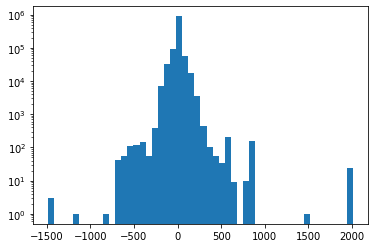

In [8]:
# The very first step is to have a look at the distributions of velocities from each cube
print(np.shape(map_array_ml))
print(np.shape(np.reshape(map_array_ml, np.shape(map_array_ml)[0]*np.shape(map_array_ml)[1])))
flat = np.reshape(map_array_ml, np.shape(map_array_ml)[0]*np.shape(map_array_ml)[1])
print(flat)

plt.clf()
plt.hist(flat, bins=50)#np.ma.masked_where(flat==0, flat))
#plt.ylim([0,10000])
plt.yscale('log')
plt.show()

# V v interesting, looks like there is a blue wing

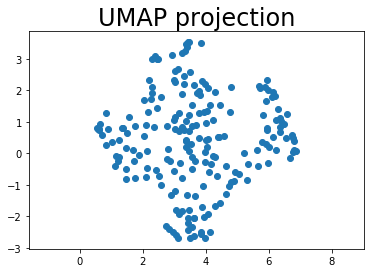

In [169]:
# umap
import umap.umap_ as umap
reducer = umap.UMAP()
embedding = reducer.fit_transform(map_array_ml)

embedding.shape

plt.scatter(embedding[:,0], embedding[:,1])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection', fontsize=24);

(201, 2)


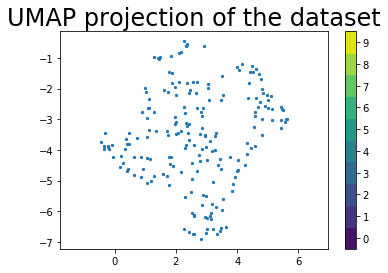

In [171]:
reducer = umap.UMAP(random_state=24)
reducer.fit(map_array_ml)
embedding = reducer.transform(map_array_ml)
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert(np.all(embedding == reducer.embedding_))
print(embedding.shape)
plt.scatter(embedding[:, 0], embedding[:, 1], cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the dataset', fontsize=24);

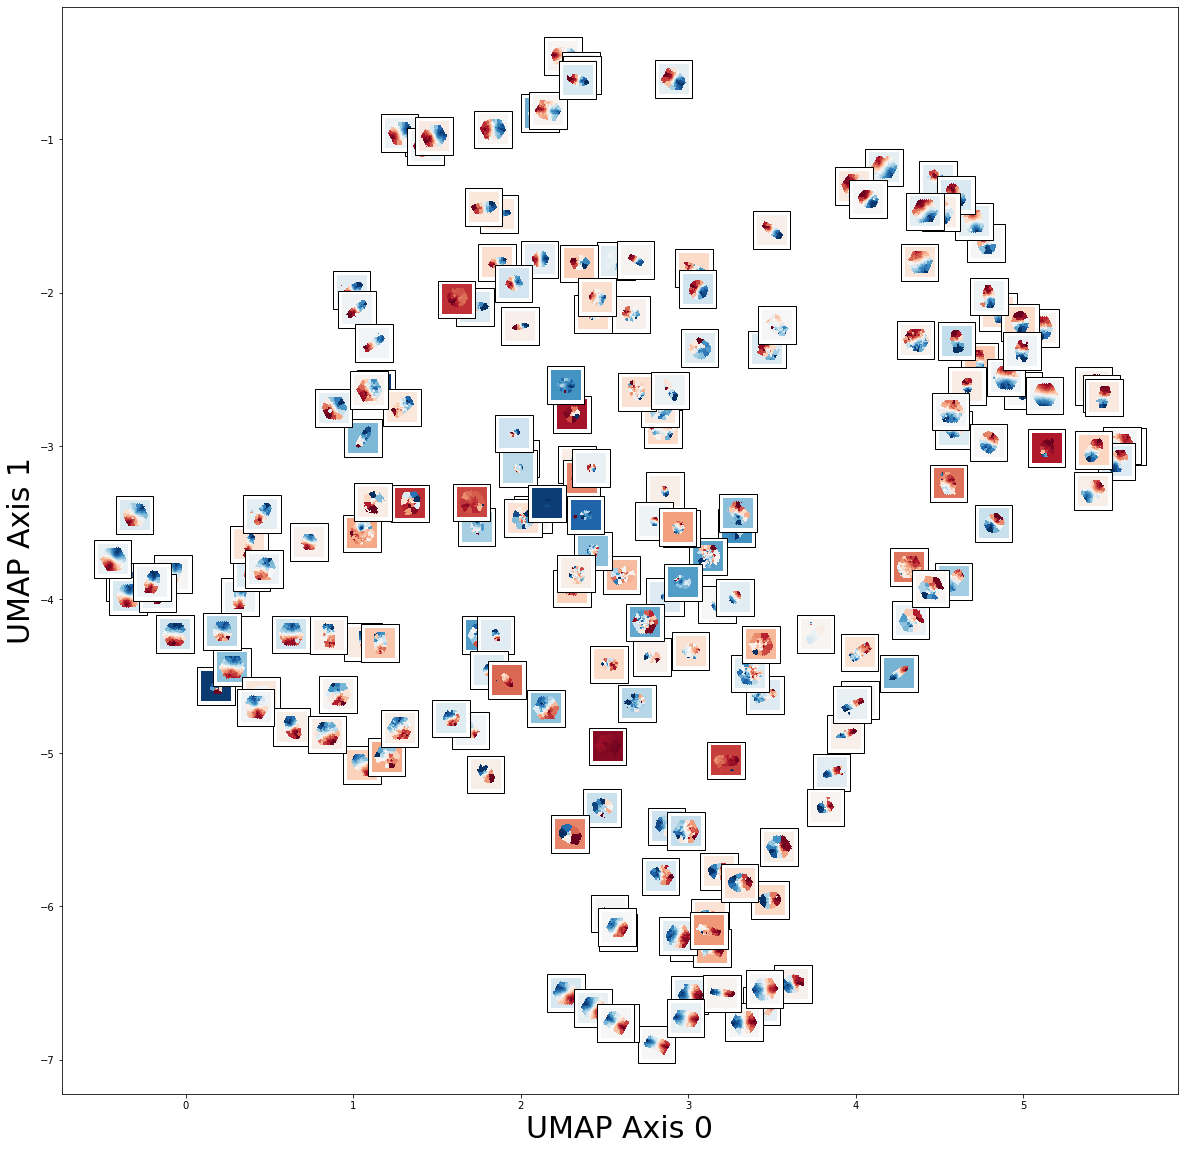

In [173]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox 
from matplotlib import pyplot as plt

def imscatter(x, y, images, ax=None, zoom=0.1):     
        if ax is None:         
                ax = plt.gca()           
        x, y = np.atleast_1d(x, y)     
        artists = []     
        for x0, y0, image0 in zip(x, y, images):
                ima = image0
                im = OffsetImage(ima, zoom=zoom, cmap='RdBu_r')   
                ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=True)         
                artists.append(ax.add_artist(ab))     
        ax.update_datalim(np.column_stack([x, y]))     
        ax.autoscale()     
        return artists
#np.reshape(map_array_ml[j,:],(shape,shape))
twod = np.reshape(map_array_ml, (np.shape(map_array_ml)[0],size, size))

fig = plt.figure(figsize=(20,20))
ax1 = plt.gca()
imscatter(embedding[:,0], embedding[:,1], np.ma.masked_where(twod==0, twod), ax=ax1, zoom=0.4)
ax1.set_xlabel('UMAP Axis 0', size=30)
ax1.set_ylabel('UMAP Axis 1', size=30)
plt.savefig('umap.pdf')#, dpi=1000)

#UMAP vs tSNE - 

In [177]:

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

(x_train, y_train), (x_test, y_test) = mnist.load_data()

img_rows, img_cols = 28, 28

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

import numpy as np

temp = []
for img in x_train:
    t = []
    for row in img:
        for i in row:
            t.append(i)
    temp.append(t)
x_train = []
x_train = temp

x_train = np.array(x_train)

x_train = x_train.reshape(60000,784)

model = Sequential()
model.add(Dense(784,activation='relu',input_dim=784))
model.add(Dense(256,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dense(784,activation='relu'))

model.compile(loss=keras.losses.mean_squared_error,
             optimizer=keras.optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=None, decay=0.0),
             metrics = ['accuracy'])

model.fit(x_train,x_train,verbose=1,epochs=10,batch_size=256)
model.save('C:\\Users\\Rohith\\Documents\\Rohith_Stuff\\Datasets\\auto_en.h5')
#del model

from keras.models import load_model
import cv2

model = load_model('C:\\Users\\Rohith\\Documents\\Rohith_Stuff\\Datasets\\auto_en.h5')

test = x_train[1].reshape(1,784)
y_test = model.predict(test)

inp_img = []
temp = []
for i in range(len(test[0])):
    if((i+1)%28 == 0):
        temp.append(test[0][i])
        inp_img.append(temp)
        temp = []
    else:
        temp.append(test[0][i])
out_img = []
temp = []
for i in range(len(y_test[0])):
    if((i+1)%28 == 0):
        temp.append(y_test[0][i])
        out_img.append(temp)
        temp = []
    else:
        temp.append(y_test[0][i])
        
inp_img = np.array(inp_img)
out_img = np.array(out_img)
        
cv2.imshow('Test Image',inp_img)
cv2.imshow('Output Image',out_img)
cv2.waitKey(0)
#view rawAutoEncoder_MNIST.py hosted with ❤ by GitHub

Using TensorFlow backend.
/Users/beckynevin/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py:5851: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/beckynevin/.keras/keras.json' mode='r' encoding='UTF-8'>
  _config = json.load(open(_config_path))
/Users/beckynevin/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


11493376/11490434 [==============================] - 1s 0us/step


ValueError: None values not supported.

In [105]:
# Gaussian mixture models
from sklearn.mixture import GaussianMixture as GMM
size = int(np.sqrt(np.shape(map_array_ml[0])[0]))
nclusters=10
model = GMM(nclusters).fit(map_array_ml)
    #np.reshape(map_array_ml,(np.shape(map_array_ml)[0],size, size) ))
print(model)
print(model.get_params)

print(model.means_)
print('\n')
print(model.covariances_)
STOP


n_components = np.arange(1, 11)
models = [GMM(n, covariance_type='full', random_state=0).fit(map_array_ml)
          for n in n_components]

plt.plot(n_components, [m.bic(map_array_ml_rot_inv) for m in models], label='BIC')
plt.plot(n_components, [m.aic(map_array_ml_rot_inv) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=10, n_init=1,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)
<bound method BaseEstimator.get_params of GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=10, n_init=1,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)>
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


[[[1.e-06 0.e+00 0.e+00 ... 0.e+00 0.e+00 0.e+00]
  [0.e+00 1.e-06 0.e+00 ... 0.e+00 0.e+00 0.e+00]
  [0.e+00 0.e+00 1.e-06 ... 0.e+00 0.e+00 0.e+00]
  ...

NameError: name 'STOP' is not defined

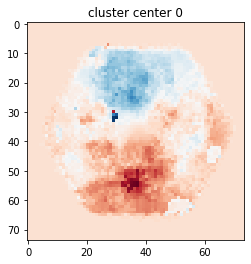

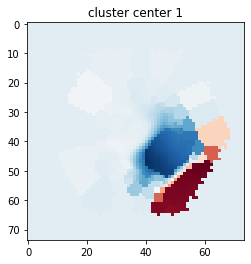

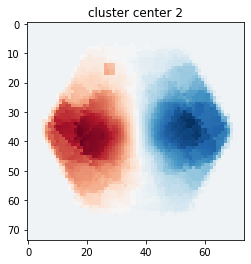

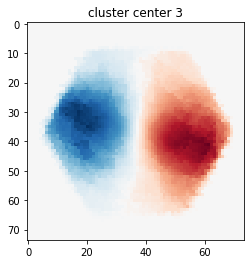

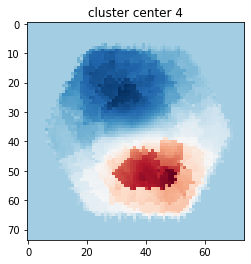

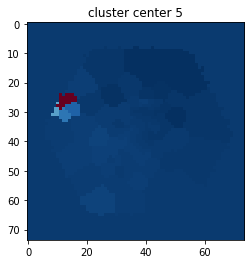

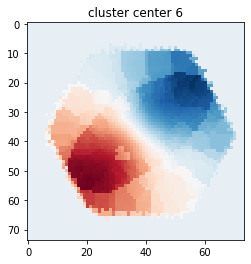

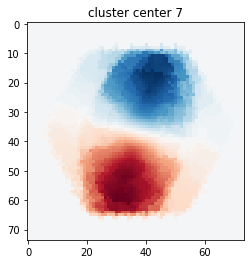

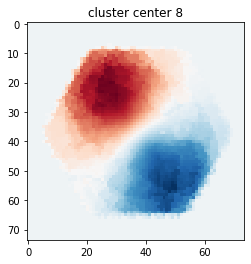

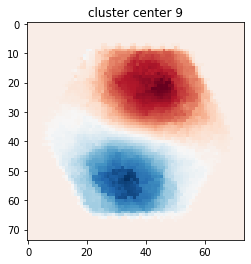

In [106]:
for j in range(nclusters):
    plt.clf()
    plt.imshow(np.reshape(model.means_[j], (size, size)), cmap='RdBu_r')
    plt.title('cluster center '+str(j))
    plt.show()

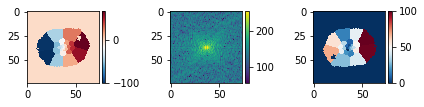

(74, 74)


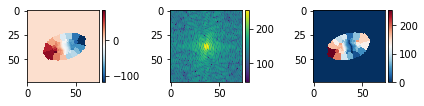

In [200]:
# It is clear that the clustering is still variant to the dipole moment
# Try to Fourier transform the image
import cv2
tester_image = np.reshape(map_array_ml[0], (size, size))
f = cv2.dft(np.float32(tester_image), flags=cv2.DFT_COMPLEX_OUTPUT)
f_shift = np.fft.fftshift(f)
f_complex = f_shift[:,:,0] + 1j*f_shift[:,:,1]
f_abs = np.abs(f_complex) + 1 # lie between 1 and 1e6
f_bounded = 20 * np.log(f_abs)
f_img = 255 * f_bounded / np.max(f_bounded)
f_img = f_img.astype(np.uint8)


fig = plt.figure()
ax0 = fig.add_subplot(131)
im0 = ax0.imshow(tester_image, cmap='RdBu_r')
plt.colorbar(im0,fraction=0.046, pad=0.04)

ax1 = fig.add_subplot(132)
im1 = ax1.imshow(f_img)
plt.colorbar(im1,fraction=0.046, pad=0.04)


inv_img = np.fft.ifft2(f_complex) # inverse F.T.
filtered_img = np.abs(inv_img)
#print(tester_image.min())
#filtered_img -= tester_image.min()

#filtered_img = filtered_img/ tester_image.max()

#filtered_img = filtered_img.astype(np.uint8)

ax2 = fig.add_subplot(133)
im2 = ax2.imshow(filtered_img, cmap='RdBu_r')
plt.colorbar(im2, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()
# So what we're seeing in this star pattern is - low frequency component towards the center
# higher frequency things are smaller structures in images

# Compare the above result to a different looking stellar velocity map

tester_image = np.reshape(map_array_ml[1], (size, size))
f = cv2.dft(np.float32(tester_image), flags=cv2.DFT_COMPLEX_OUTPUT)
f_shift = np.fft.fftshift(f)
f_complex = f_shift[:,:,0] + 1j*f_shift[:,:,1]
f_abs = np.abs(f_complex) + 1 # lie between 1 and 1e6
f_bounded = 20 * np.log(f_abs)
f_img = 255 * f_bounded / np.max(f_bounded)
f_img = f_img.astype(np.uint8)

fig = plt.figure()
ax0 = fig.add_subplot(131)
im0 = ax0.imshow(tester_image, cmap='RdBu_r')
plt.colorbar(im0,fraction=0.046, pad=0.04)

ax1 = fig.add_subplot(132)
im1 = ax1.imshow(f_img)
plt.colorbar(im1,fraction=0.046, pad=0.04)

print(np.shape(f_complex))
inv_img = np.fft.ifft2(f_complex) # inverse F.T.
filtered_img = np.abs(inv_img)
filtered_img -= filtered_img.min()
filtered_img = filtered_img*255 / filtered_img.max()
filtered_img = filtered_img.astype(np.uint8)

ax2 = fig.add_subplot(133)
im2 = ax2.imshow(filtered_img, cmap='RdBu_r')
plt.colorbar(im2, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

(201, 5476)


/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]


[[ 7.93089150e-10  2.26355746e-03 -4.86121248e-04 ... -1.58575440e-03
   4.92965920e-04  7.15529992e-04]
 [ 2.26355746e-03  2.23519581e+05 -5.47334550e+04 ...  9.01523282e+03
   5.19419888e+04  5.30018524e+04]
 [-4.86121248e-04 -5.47334550e+04  2.53062780e+05 ...  1.77302134e+04
   6.27337260e+04  2.05505697e+04]
 ...
 [-1.58575440e-03  9.01523282e+03  1.77302134e+04 ...  1.35300201e+05
  -1.43927854e+04 -1.74782879e+04]
 [ 4.92965920e-04  5.19419888e+04  6.27337260e+04 ... -1.43927854e+04
   1.61304794e+05 -4.24850367e+04]
 [ 7.15529992e-04  5.30018524e+04  2.05505697e+04 ... -1.74782879e+04
  -4.24850367e+04  1.37314801e+05]]
GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=6, n_init=1, precisions_init=None,
                random_state=None, reg_covar=100.0, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)
<bound method BaseEstimator.get_params of GaussianMixture(c

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

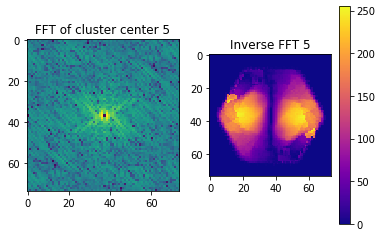

In [203]:
# Make everything into an FFT:
print(np.shape(map_array_ml))
map_array_ml_FFT = np.zeros((np.shape(map_array_ml)[0], size, size))
for j in range(np.shape(map_array_ml)[0]):
    tester_image = np.reshape(map_array_ml[j], (size, size))
    f = cv2.dft(np.float32(tester_image), flags=cv2.DFT_COMPLEX_OUTPUT)
    f_shift = np.fft.fftshift(f)
    f_complex = f_shift[:,:,0] + 1j*f_shift[:,:,1]
    f_abs = np.abs(f_complex) + 1 # lie between 1 and 1e6
    f_bounded = np.log(f_abs)
    #f_img = 255 * f_bounded / np.max(f_bounded)
    #f_img = f_img.astype(np.uint8)
    map_array_ml_FFT[j,:,:] = f_complex
    
# Gaussian mixture models
from sklearn.mixture import GaussianMixture as GMM
size = int(np.sqrt(np.shape(map_array_ml[0])[0]))
nclusters=6
reshape_FFT = np.reshape(map_array_ml_FFT, (np.shape(map_array_ml_FFT)[0], size*size))

cov = np.cov(reshape_FFT, rowvar=False, bias=True)
print(cov)
model = GMM(nclusters, reg_covar = 1e2).fit(reshape_FFT)
    #np.reshape(map_array_ml,(np.shape(map_array_ml)[0],size, size) ))
print(model)
print(model.get_params)

print(model.means_)
print('\n')
print(model.covariances_)
for j in range(nclusters):
    plt.clf()
    fig = plt.figure()
    ax0 = fig.add_subplot(121)
    
    f_abs = np.abs(model.means_[j]) + 1 # lie between 1 and 1e6
    f_bounded = 20 * np.log(f_abs)
    f_img = 255 * f_bounded / np.max(f_bounded)
    f_img = f_img.astype(np.uint8)
    im0 = ax0.imshow(np.reshape(f_img, (size, size)))
    ax0.set_title('FFT of cluster center '+str(j))
    
    
    # So what this actually is f_complex gone through these transformation:
    
    fft_2d = np.reshape(model.means_[j], (size,size))
    
    inv_img = np.fft.ifft2(fft_2d) # inverse F.T.
    #filtered_img = np.abs(inv_img)
    
    filtered_img = np.abs(inv_img)
    filtered_img -= filtered_img.min()
    filtered_img = filtered_img*255 / filtered_img.max()
    filtered_img = filtered_img.astype(np.uint8)
    ax1 = fig.add_subplot(122)
    im1 = ax1.imshow(filtered_img, cmap='plasma')
    ax1.set_title('Inverse FFT '+str(j))
    plt.colorbar(im1)
    
   
    
    plt.savefig('FFT_GMM_cluster_center_'+str(j)+'.pdf')
    
    
    
# Perhaps this got rid of some rotational problems?
# Let us investigate by looking at one of the clusters

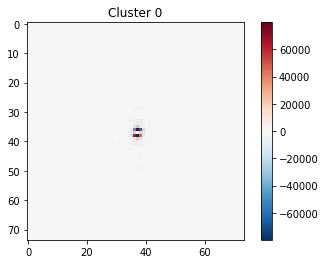

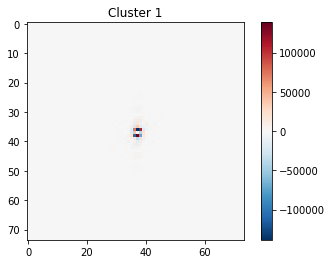

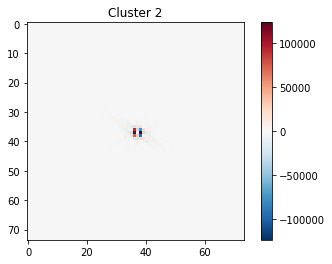

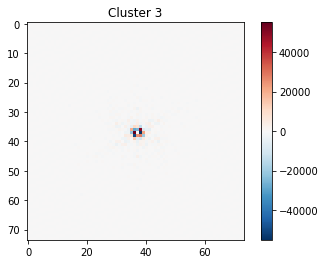

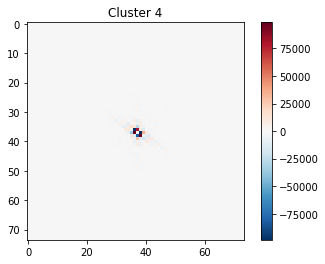

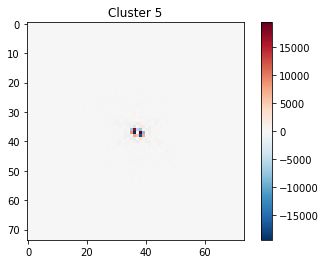

[2 3 5 0 5 5 0 3 0 1 5 1 1 4 2 5 0 5 1 5 5 5 3 4 5 1 5 3 0 0 5 5 1 5 5 2 2
 5 5 4 0 3 5 0 4 3 5 5 5 2 5 5 4 5 5 5 2 1 1 4 5 2 5 4 1 3 0 0 3 5 3 5 0 5
 5 0 3 5 3 0 5 4 0 4 3 0 5 0 3 2 5 0 3 5 5 3 2 5 3 5 5 1 4 5 5 3 3 0 5 1 5
 4 5 0 1 2 5 3 1 5 5 5 5 2 3 2 5 5 0 3 3 1 0 3 5 5 3 2 2 2 4 3 4 0 2 5 5 4
 0 0 1 5 2 5 3 3 4 2 5 2 3 0 5 5 3 5 0 4 5 2 4 1 3 5 4 5 3 3 1 3 4 5 0 2 5
 5 3 0 5 1 3 5 5 3 1 5 5 5 2 5 5]


<Figure size 432x288 with 0 Axes>

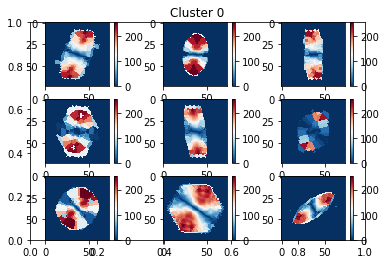

<Figure size 432x288 with 0 Axes>

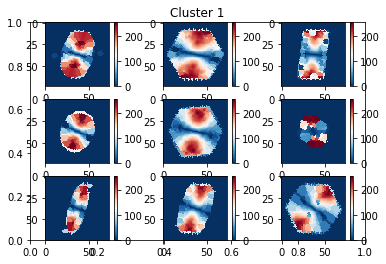

<Figure size 432x288 with 0 Axes>

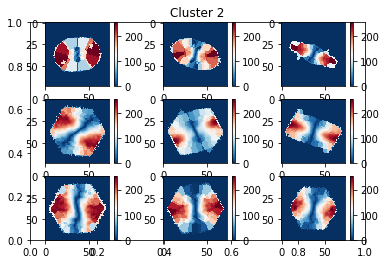

<Figure size 432x288 with 0 Axes>

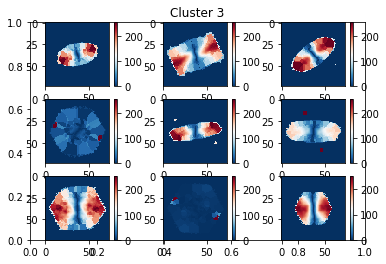

<Figure size 432x288 with 0 Axes>

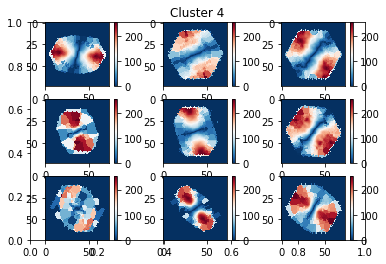

<Figure size 432x288 with 0 Axes>

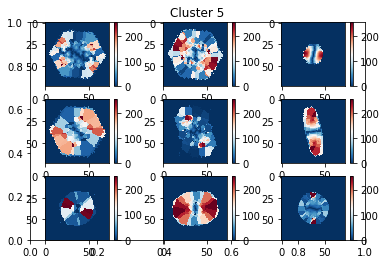

In [207]:
    
# Perhaps this got rid of some rotational problems?
# Let us investigate by looking at one of the clusters
'''fft_2d = np.reshape(model.means_[j], (size,size))
    
inv_img = np.fft.ifft2(fft_2d) # inverse F.T.
#filtered_img = np.abs(inv_img)

filtered_img = np.abs(inv_img)
filtered_img -= filtered_img.min()
filtered_img = filtered_img*255 / filtered_img.max()
filtered_img = filtered_img.astype(np.uint8)
ax1 = fig.add_subplot(122)
im1 = ax1.imshow(filtered_img, cmap='plasma')
ax1.set_title('Inverse FFT '+str(j))'''

clusters = model.fit_predict(reshape_FFT)
# the center of the cluster is the arithmetic mean of all the 
# points belonging to the cluster, each point in a cluster is closer
# to that cluster center than to any other cluster centers

# Visualizing what the heck this actually looks like

centers = model.means_.reshape(nclusters, shape, shape)


for j in range(nclusters):
    plt.clf()
    plt.imshow(centers[j], cmap='RdBu_r')#, vmin=-100, vmax=100)
    plt.colorbar()
    plt.title('Cluster '+str(j))
    plt.show()


# My next question is is there a way to visualize multiple maps within each class
print(clusters)
# these are the cluster IDs of each galaxy
cluster={}
#cluster_name=[]
for n in range(nclusters):
    
    cluster[n]=[]
    for j in range(np.shape(map_array_ml)[0]):
        if clusters[j]==n:
            inv_img = np.fft.ifft2(np.reshape(reshape_FFT[j,:],(shape,shape))) # inverse F.T.
            #filtered_img = np.abs(inv_img)

            filtered_img = np.abs(inv_img)
            filtered_img -= filtered_img.min()
            filtered_img = filtered_img*255 / filtered_img.max()
            filtered_img = filtered_img.astype(np.uint8)
            cluster[n].append(filtered_img)
    #cluster_name.append(str(cluster[n]))
    
# Plot multiple examples of each class
for i in range(nclusters):
    plt.clf()
    fig=plt.figure()
    #fig.subplots_adjust(hspace = .5, wspace=.001)
    plt.title('Cluster '+str(i))
    
    if np.shape(cluster[i])[0] < 9:
        for j in range(np.shape(cluster[i])[0]):
            ax = fig.add_subplot(3,3,j+1)
            im = ax.imshow(cluster[i][j], cmap='RdBu_r')#, vmin=-100, vmax=100)
            plt.colorbar(im)
        plt.show()
    else:
        for j in range(9):
            ax = fig.add_subplot(3,3,j+1)
            im = ax.imshow(cluster[i][j], cmap='RdBu_r')#, vmin=-100, vmax=100)
            plt.colorbar(im)
        plt.show()


In [211]:
# It seems like the fourier transform might not be working that well
# Or it is at least very hard to interpret
from minisom import MiniSom
som = MiniSom(30, 30, 5476, sigma=4,
              learning_rate=0.5, neighborhood_function='triangle')
som.pca_weights_init(map_array_ml)
print("Training...")
som.train_random(data, 5000, verbose=True)  # random training
print("\n...ready!")

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/minisom.py:300: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + c2*pc[pc_order[1]]


Training...
 [ 5000 / 5000 ] 100% - 0:00:00 left 
 quantization error: 67.56500312857115
 topographic error: 0.6915422885572139

...ready!


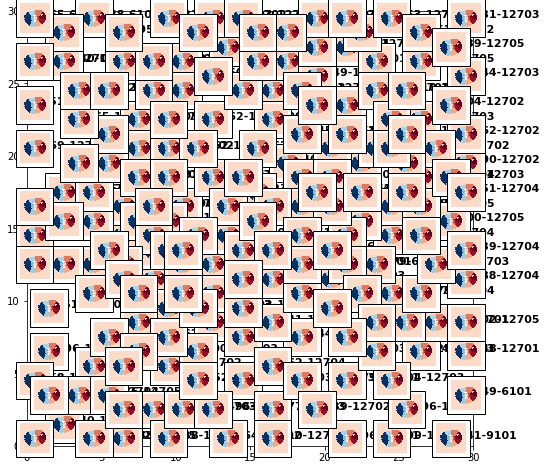

<Figure size 432x288 with 0 Axes>

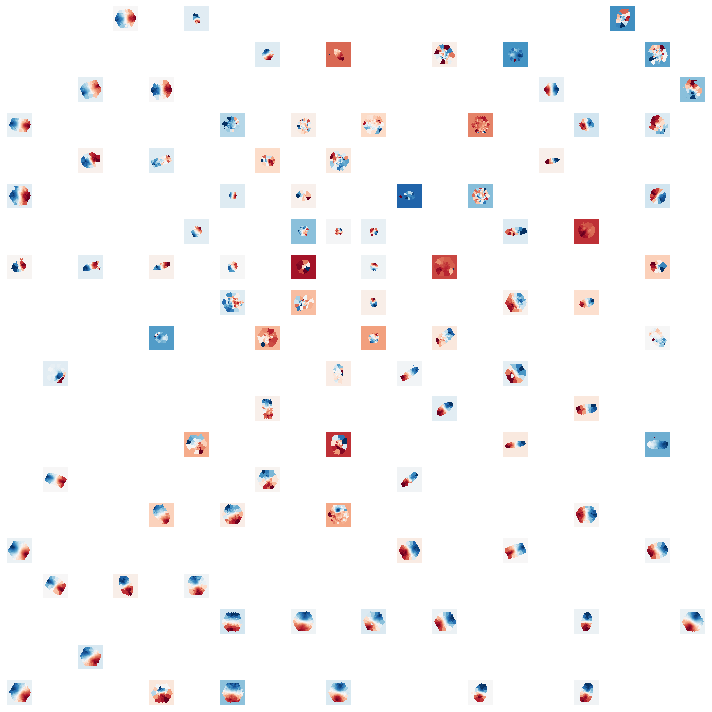

In [221]:
num = ifu_name
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(111)
wmap = {}
im = 0
for x, t in zip(data, num):  # scatterplot
    w = som.winner(x)
    wmap[w] = im
    imscatter(w[0]+.5,w[1]+.5, np.ma.masked_where(twod==0, twod), ax=ax1, zoom=0.4)

    ax1.text(w[0]+.5,  w[1]+.5,  str(t), fontdict={'weight': 'bold',  'size': 11})
    im = im + 1
ax1.axis([0, som.get_weights().shape[0], 0,  som.get_weights().shape[1]])
plt.savefig('som_digts.png')
plt.show()

plt.clf()
plt.figure(figsize=(10, 10), facecolor='white')
cnt = 0
for j in reversed(range(20)):  # images mosaic
    for i in range(20):
        plt.subplot(20, 20, cnt+1, frameon=False,  xticks=[],  yticks=[])
        if (i, j) in wmap:
            plt.imshow(np.reshape(map_array_ml[wmap[(i, j)]],(size,size)),
                       cmap='RdBu_r', interpolation='nearest')
        else:
            plt.imshow(np.zeros((8, 8)),  cmap='Greys')
        cnt = cnt + 1

plt.tight_layout()
plt.savefig('som_digts_imgs.png')
plt.show()

In [ ]:
Principal component analysis (PCA)
Anomaly detection
Autoencoders
Deep belief nets
Hebbian learning
Generative adversarial networks (GANs)
Self-organizing maps

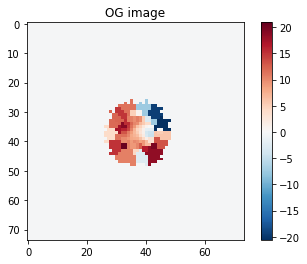

coeffs shape (2,)
(array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), (array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])))
(39, 39)


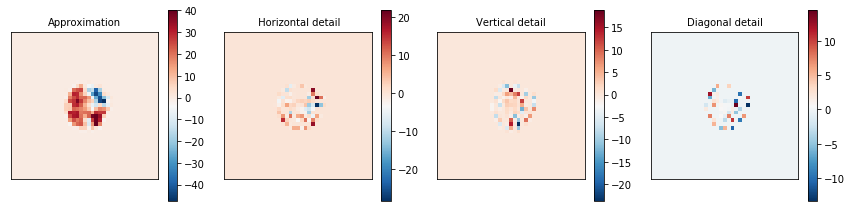

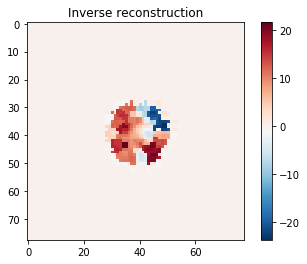

In [163]:
# What about using a fourier transform that is localized in space - wavelet
import pywt
# Wavelet transform of image, and plot approximation and details
tester_image = np.reshape(map_array_ml[100], (size, size))

plt.imshow(tester_image, cmap='RdBu_r')
plt.title('OG image')
plt.colorbar()
plt.show()
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs2 = pywt.dwt2(tester_image, 'bior1.3')
print('coeffs shape',np.shape(coeffs2))
print(coeffs2)
LL, (LH, HL, HH) = coeffs2
print(np.shape(LL))
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    im = ax.imshow(a, interpolation="nearest", cmap='RdBu_r')
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.colorbar(im)

fig.tight_layout()
plt.show()

plt.imshow(pywt.idwt2(coeffs2, 'haar'), cmap='RdBu_r')
plt.title('Inverse reconstruction')
plt.colorbar()
plt.show()

'''plt.imshow(tester_image-pywt.idwt2(coeffs2))#, 'haar'))
plt.colorbar()
plt.show()'''
size_DWT = np.shape(LL)[0]
map_array_ml_DWT_coeffs = np.zeros((np.shape(map_array_ml)[0], size_DWT, size_DWT))

map_array_ml_DWT_LL = np.zeros((np.shape(map_array_ml)[0], size_DWT, size_DWT))
map_array_ml_DWT_LH = np.zeros((np.shape(map_array_ml)[0], size_DWT, size_DWT))
map_array_ml_DWT_HL = np.zeros((np.shape(map_array_ml)[0], size_DWT, size_DWT))
map_array_ml_DWT_HH = np.zeros((np.shape(map_array_ml)[0], size_DWT, size_DWT))
for j in range(np.shape(map_array_ml)[0]):
    tester_image = np.reshape(map_array_ml[j], (size, size))
    coeffs2 = pywt.dwt2(tester_image, 'bior1.3')
    LL, (LH, HL, HH) = coeffs2
    map_array_ml_DWT_LL[j,:,:] = LL
    map_array_ml_DWT_LH[j,:,:] = LH
    map_array_ml_DWT_HL[j,:,:] = HL
    map_array_ml_DWT_HH[j,:,:] = HH

(2,)
(array([0., 0., 0., ..., 0., 0., 0.]), (array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.])))


ValueError: Axis greater than data dimensions

<Figure size 432x288 with 0 Axes>

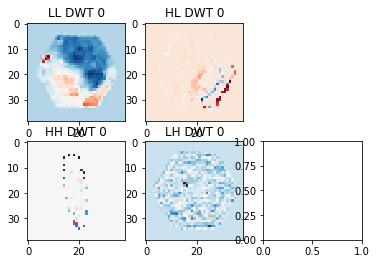

In [162]:
# Gaussian mixture models
from sklearn.mixture import GaussianMixture as GMM
size = int(np.sqrt(np.shape(map_array_ml[0])[0]))
nclusters=5
reshape_DWT_LL = np.reshape(map_array_ml_DWT_LL, (np.shape(map_array_ml_DWT_LL)[0], size_DWT*size_DWT))
model_LL = GMM(nclusters).fit(reshape_DWT_LL)

reshape_DWT_HL = np.reshape(map_array_ml_DWT_HL, (np.shape(map_array_ml_DWT_HL)[0], size_DWT*size_DWT))
model_HL = GMM(nclusters).fit(reshape_DWT_HL)

reshape_DWT_LH = np.reshape(map_array_ml_DWT_LH, (np.shape(map_array_ml_DWT_LH)[0], size_DWT*size_DWT))
model_LH = GMM(nclusters).fit(reshape_DWT_LH)

reshape_DWT_HH = np.reshape(map_array_ml_DWT_HH, (np.shape(map_array_ml_DWT_HH)[0], size_DWT*size_DWT))
model_HH = GMM(nclusters).fit(reshape_DWT_HH)
    #np.reshape(map_array_ml,(np.shape(map_array_ml)[0],size, size) ))
'''print(model)
print(model.get_params)

print(model.means_)
print('\n')
print(model.covariances_)'''
for j in range(nclusters):
    plt.clf()
    fig = plt.figure()
    ax0 = fig.add_subplot(231)
    im0 = ax0.imshow(np.reshape(model_LL.means_[j], (size_DWT, size_DWT)), cmap='RdBu_r')
    ax0.set_title('LL DWT '+str(j))
    
    ax1 = fig.add_subplot(232)
    im1 = ax1.imshow(np.reshape(model_HL.means_[j], (size_DWT, size_DWT)), cmap='RdBu_r')
    ax1.set_title('HL DWT '+str(j))
    
    ax2 = fig.add_subplot(234)
    im2 = ax2.imshow(np.reshape(model_HH.means_[j], (size_DWT, size_DWT)), cmap='RdBu_r')
    ax2.set_title('HH DWT '+str(j))
    
    ax3 = fig.add_subplot(235)
    im3 = ax3.imshow(np.reshape(model_LH.means_[j], (size_DWT, size_DWT)), cmap='RdBu_r')
    ax3.set_title('LH DWT '+str(j))
    
    '''plt.show()
    continue'''
    coeffs2 = model_LL.means_[j], (model_LH.means_[j], model_HL.means_[j], model_HH.means_[j])
    print(np.shape(coeffs2))
    print(coeffs2)
    ax4 = fig.add_subplot(236)
    im4 = ax4.imshow(pywt.idwt2(coeffs2, 'haar'), cmap='RdBu_r')
    ax4.set_title('Inverse DWT '+str(j))
    
    plt.show()
    
    
    
# Now you will 

(201, 5476)


/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=2, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)
<bound method BaseEstimator.get_params of GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=2, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)>
[[4.90604343 5.27375999 5.27226663 ... 5.35937192 5.37615696 5.30036375]
 [5.94514883 6.17022024 6.18985674 ... 6.23300553 6.22769664 6.26401181]]


[[[1.26418158 0.24022651 0.2673978  ... 0.1260011  0.10936818 0.21892227]
  [0.24022651 0.55906854 0.25863536 ... 0.11375786 0.20973034 0.16636036]
  [0.2673978  0.25863536 0.64625167 ... 0.11838181

<Figure size 432x288 with 0 Axes>

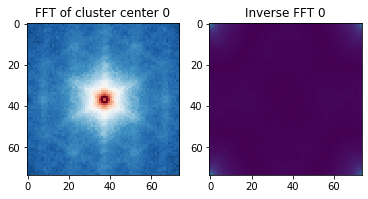

<Figure size 432x288 with 0 Axes>

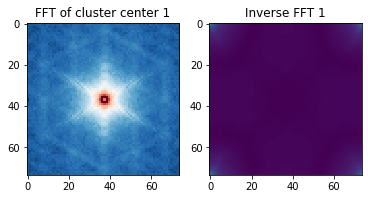

In [25]:
size = int(np.sqrt(np.shape(map_array_ml[0])[0]))
tester = np.reshape(map_array_ml[0],(size,size))
y_pred = model.predict(tester)
print(y_pred)

ValueError: Expected the input data X have 5476 features, but got 74 features

size =  74
should be shape 6 80 480


<Figure size 432x288 with 0 Axes>

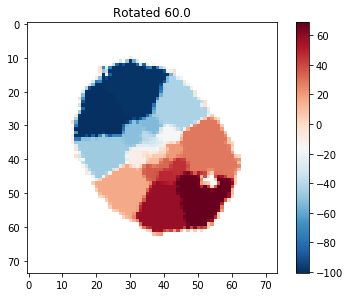

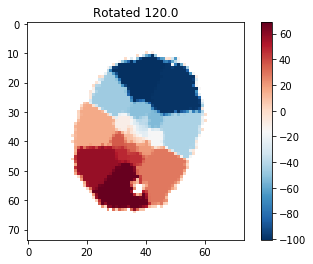

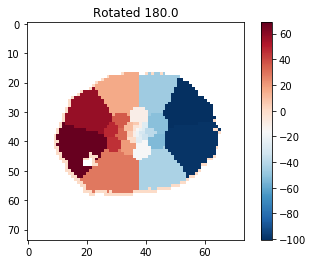

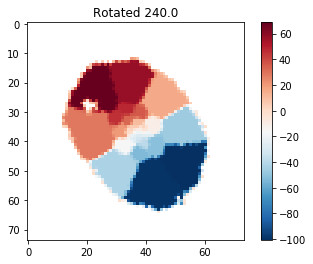

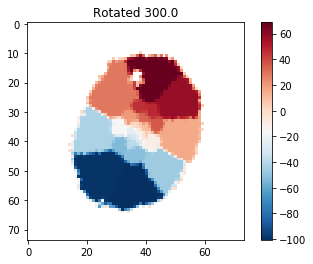

done


In [30]:
# First try to make the maps:
# 1. Scale - invariant ()
# 2. Rotation - invariant (rotate)
# 3. Size - invariant (zoom in)


from matplotlib import pyplot as plt
from skimage import transform
from skimage import data
from skimage.feature import corner_harris, corner_subpix, corner_peaks
from skimage.transform import warp, AffineTransform
import math




size = int(np.sqrt(np.shape(map_array_ml[0])))
n_gals = int(np.shape(map_array_ml)[0])

# rotation is in radians

input_rot = math.radians(45)
tform = AffineTransform(rotation=input_rot)
test_image = np.reshape(np.array(map_array_ml[3]),(size, size))
test_image = np.ma.masked_where(test_image==0, test_image)
rot = warp(test_image, tform.inverse)




plt.clf()
fig = plt.figure()
ax0 = fig.add_subplot(231)
im0 = ax0.imshow(test_image, cmap='RdBu_r')
plt.colorbar(im0,fraction=0.046, pad=0.04)
ax0.set_xticks([0,size/2, size])
ax0.set_yticks([0,size/2, size])

ax0.set_xticklabels([-size/4, 0, size/4])
ax0.set_yticklabels([-size/4, 0, size/4])

print('size = ', size)

shift_y, shift_x = np.array(test_image.shape[:2]) / 2.
tf_rotate = transform.SimilarityTransform(rotation=np.deg2rad(60))
tf_shift = transform.SimilarityTransform(translation=[-shift_x, -shift_y])
tf_shift_inv = transform.SimilarityTransform(translation=[shift_x, shift_y])

rot = transform.warp(test_image, (tf_shift + (tf_rotate + tf_shift_inv)).inverse)
rot = np.ma.masked_where(rot==0, rot)

ax1 = fig.add_subplot(232)
im1 = ax1.imshow(rot, cmap='RdBu_r')
ax1.set_title('Rot = 60')
ax1.axis('off')

#plt.colorbar(im1)

shift_y, shift_x = np.array(test_image.shape[:2]) / 2.
tf_rotate = transform.SimilarityTransform(rotation=np.deg2rad(120))
tf_shift = transform.SimilarityTransform(translation=[-shift_x, -shift_y])
tf_shift_inv = transform.SimilarityTransform(translation=[shift_x, shift_y])

rot = transform.warp(test_image, (tf_shift + (tf_rotate + tf_shift_inv)).inverse)
rot = np.ma.masked_where(rot==0, rot)

ax2 = fig.add_subplot(233)
im2 = ax2.imshow(rot, cmap='RdBu_r')
ax2.set_title('Rot = 120')
ax2.axis('off')
#plt.colorbar(im2)

shift_y, shift_x = np.array(test_image.shape[:2]) / 2.
tf_rotate = transform.SimilarityTransform(rotation=np.deg2rad(180))
tf_shift = transform.SimilarityTransform(translation=[-shift_x, -shift_y])
tf_shift_inv = transform.SimilarityTransform(translation=[shift_x, shift_y])

rot = transform.warp(test_image, (tf_shift + (tf_rotate + tf_shift_inv)).inverse)
rot = np.ma.masked_where(rot==0, rot)

ax3 = fig.add_subplot(234)
im3 = ax3.imshow(rot, cmap='RdBu_r')
ax3.set_title('Rot = 180')
ax3.axis('off')

shift_y, shift_x = np.array(test_image.shape[:2]) / 2.
tf_rotate = transform.SimilarityTransform(rotation=np.deg2rad(240))
tf_shift = transform.SimilarityTransform(translation=[-shift_x, -shift_y])
tf_shift_inv = transform.SimilarityTransform(translation=[shift_x, shift_y])

rot = transform.warp(test_image, (tf_shift + (tf_rotate + tf_shift_inv)).inverse)
rot = np.ma.masked_where(rot==0, rot)
ax4 = fig.add_subplot(235)
im4 = ax4.imshow(rot, cmap='RdBu_r')
ax4.set_title('Rot = 240')
ax4.axis('off')

shift_y, shift_x = np.array(test_image.shape[:2]) / 2.
tf_rotate = transform.SimilarityTransform(rotation=np.deg2rad(300))
tf_shift = transform.SimilarityTransform(translation=[-shift_x, -shift_y])
tf_shift_inv = transform.SimilarityTransform(translation=[shift_x, shift_y])

rot = transform.warp(test_image, (tf_shift + (tf_rotate + tf_shift_inv)).inverse)
rot = np.ma.masked_where(rot==0, rot)
ax5 = fig.add_subplot(236)
im5 = ax5.imshow(rot, cmap='RdBu_r')
ax5.set_title('Rot = 300')
ax5.axis('off')
#plt.colorbar(im3)
plt.tight_layout()
plt.savefig('rotation_invariant.pdf')


# What if we created a new map_array_ml where it was populated with each galaxy rotated around
# its center?
n_rot =6
print('should be shape', n_rot, n_gals, n_rot*n_gals)
map_array_ml_rot_inv = np.zeros((n_rot*n_gals,shape**2))#np.zeros((len(plateifu_list),74**2))
counter=0
for j in range(n_gals-1):
    test_image = np.reshape(np.array(map_array_ml[j]),(size, size))
    
    for i in range(n_rot):
        # First, append with the OG image if i==0
        if i==0:
            test_image = np.ma.masked_where(np.array(map_array_ml[j])==0, np.array(map_array_ml[j]))
            map_array_ml_rot_inv[counter,:] = np.reshape(test_image, (size**2))
        else:
            test_image = np.reshape(np.array(map_array_ml[j]),(size, size))
            test_image = np.ma.masked_where(test_image==0, test_image)
            

            shift_y, shift_x = np.array(test_image.shape[:2]) / 2.
            tf_rotate = transform.SimilarityTransform(rotation=np.deg2rad((360/n_rot)*i))
            tf_shift = transform.SimilarityTransform(translation=[-shift_x, -shift_y])
            tf_shift_inv = transform.SimilarityTransform(translation=[shift_x, shift_y])

            rot = transform.warp(test_image, (tf_shift + (tf_rotate + tf_shift_inv)).inverse)
            rot = np.ma.masked_where(rot==0, rot)
            
            if j ==0:
                plt.clf()
                plt.imshow(rot, cmap='RdBu_r')
                plt.title('Rotated '+str((360/n_rot)*i))
                plt.colorbar()
                plt.show()
            map_array_ml_rot_inv[counter,:] = np.reshape(rot, (size**2))
        
        counter+=1
print('done')   

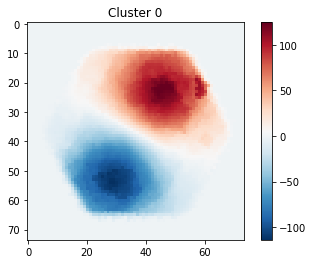

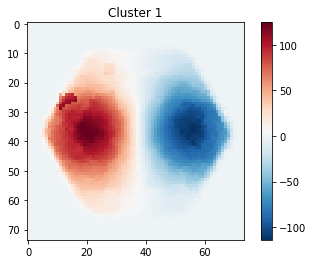

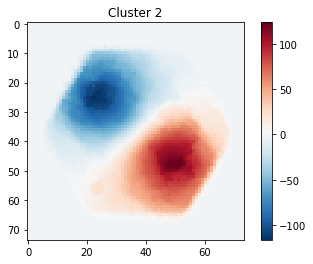

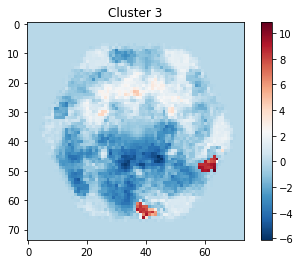

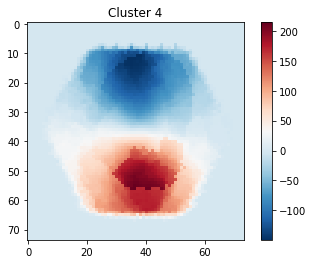

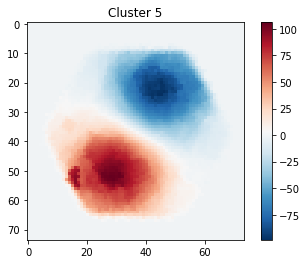

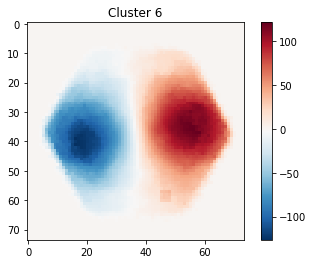

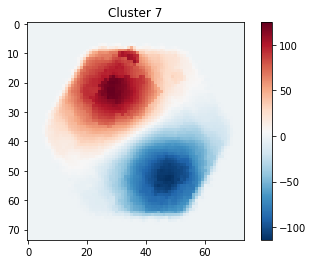

number of inputs 480
[6 2 5 1 7 0 3 3 3 3 2 5 3 3 3 3 3 3 0 6 2 5 1 7 3 3 3 3 3 3 3 3 3 3 3 3 0
 6 2 5 1 7 1 7 0 6 2 4 3 3 2 3 5 3 4 1 7 0 6 2 3 3 3 5 3 3 4 1 7 0 6 2 5 1
 7 0 6 2 1 7 0 6 4 5 6 2 5 1 7 0 3 3 3 3 3 3 0 6 2 5 1 7 5 5 1 7 0 2 5 1 7
 0 6 2 3 3 3 3 3 3 6 2 5 1 7 0 3 3 3 3 3 3 5 1 7 0 2 4 7 0 6 2 5 1 3 3 3 3
 3 3 4 1 7 0 6 2 3 3 3 3 3 3 3 3 3 3 3 3 7 0 2 5 5 1 0 6 2 5 1 7 3 3 3 3 3
 3 6 2 5 1 7 0 4 5 1 7 0 2 3 2 5 3 3 3 3 3 3 3 3 3 2 5 5 1 7 0 2 4 1 7 0 6
 3 3 3 3 3 3 3 3 3 3 3 3 7 0 6 2 4 1 0 6 2 5 1 7 1 7 0 6 2 5 3 3 3 3 3 3 0
 6 2 5 1 7 7 0 6 2 5 1 1 7 0 6 2 5 6 2 5 1 7 0 3 3 3 3 3 3 3 3 3 3 3 3 6 2
 4 1 7 0 3 3 3 3 3 3 3 3 3 3 3 3 7 0 6 4 5 1 2 5 1 7 0 6 2 5 1 7 0 6 3 3 3
 3 3 3 6 4 5 1 7 0 5 1 7 0 6 2 5 1 7 0 6 2 7 0 6 2 5 1 3 3 5 3 3 3 6 2 5 1
 7 0 3 3 3 3 3 3 7 0 6 2 5 1 5 1 7 0 6 4 1 7 0 6 2 5 0 2 4 5 1 7 0 6 2 5 1
 7 1 7 0 3 3 5 3 3 3 3 3 3 1 7 0 6 2 5 3 3 3 3 3 3 3 3 2 5 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 7 0 2 5 5 1 5 1 7 0 6 2 6 2 5 1 7 0 3 3 3 3 3 3 3 3 3 3 3 3]


<Figure size 432x288 with 0 Axes>

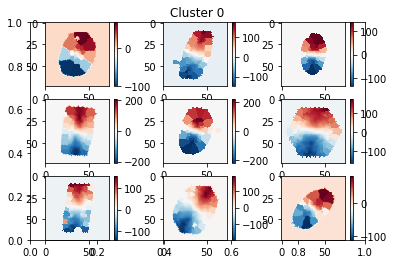

<Figure size 432x288 with 0 Axes>

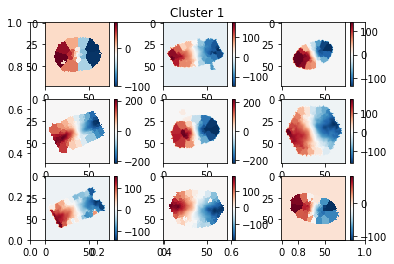

<Figure size 432x288 with 0 Axes>

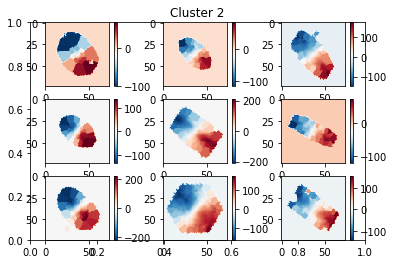

<Figure size 432x288 with 0 Axes>

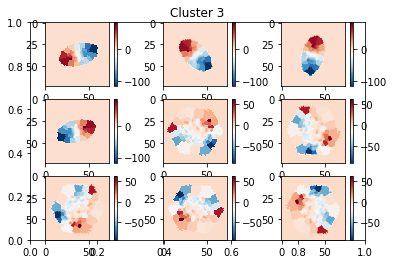

<Figure size 432x288 with 0 Axes>

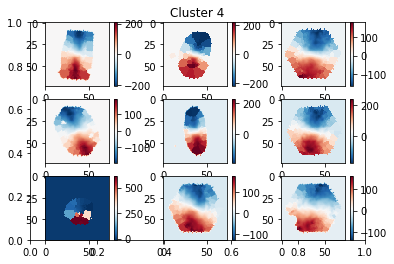

<Figure size 432x288 with 0 Axes>

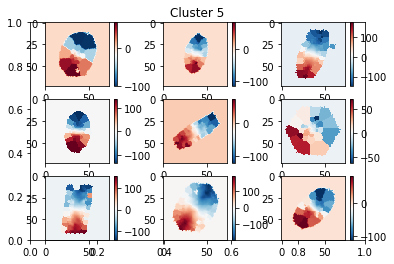

<Figure size 432x288 with 0 Axes>

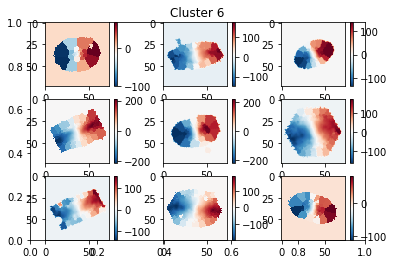

<Figure size 432x288 with 0 Axes>

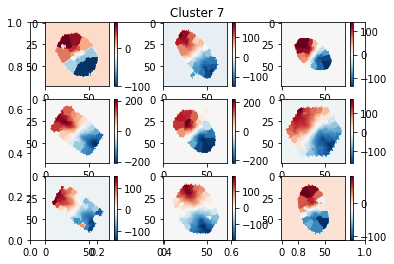

In [35]:
# Try k-means - this tutorial does the digits - https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html
#print(np.shape(map_array_ml), np.shape(projected), np.shape(components))

from sklearn.cluster import KMeans

# the data needs to be in shape (n_things, x*y), where x and y are the dimensions of each map
# I'm really not sure what to do if the dimensions are different
nclusters=8

kmeans = KMeans(n_clusters=nclusters, random_state=0)
clusters = kmeans.fit_predict(map_array_ml_rot_inv)
# the center of the cluster is the arithmetic mean of all the 
# points belonging to the cluster, each point in a cluster is closer
# to that cluster center than to any other cluster centers

# Visualizing what the heck this actually looks like

centers = kmeans.cluster_centers_.reshape(nclusters, shape, shape)


for j in range(nclusters):
    plt.clf()
    plt.imshow(centers[j], cmap='RdBu_r')#, vmin=-100, vmax=100)
    plt.colorbar()
    plt.title('Cluster '+str(j))
    plt.show()

print('number of inputs', np.shape(map_array_ml_rot_inv)[0])

# My next question is is there a way to visualize multiple maps within each class
print(clusters)
# these are the cluster IDs of each galaxy
cluster={}
#cluster_name=[]
for n in range(nclusters):
    
    cluster[n]=[]
    for j in range(np.shape(map_array_ml_rot_inv)[0]):
        if clusters[j]==n:
            cluster[n].append(np.reshape(map_array_ml_rot_inv[j,:],(shape,shape)))
    #cluster_name.append(str(cluster[n]))
nclusters_list = np.arange(0,nclusters)



# Plot multiple examples of each class
for i in range(nclusters):
    plt.clf()
    fig=plt.figure()
    #fig.subplots_adjust(hspace = .5, wspace=.001)
    plt.title('Cluster '+str(i))
    
    if np.shape(cluster[i])[0] < 9:
        for j in range(np.shape(cluster[i])[0]):
            ax = fig.add_subplot(3,3,j+1)
            im = ax.imshow(cluster[i][j], cmap='RdBu_r')#, vmin=-100, vmax=100)
            plt.colorbar(im)
        plt.show()
    else:
        for j in range(9):
            ax = fig.add_subplot(3,3,j+1)
            im = ax.imshow(cluster[i][j], cmap='RdBu_r')#, vmin=-100, vmax=100)
            plt.colorbar(im)
        plt.show()
# Interestingly, without any pre-processing, one thing k-means sorts by is the direction of the velocity gradient.
# This applies to cluster 1, 5, 6, and 8, which are all oriented differently but basically the same type of map.
# k-menas also sorts by different sorts of irregularities.
# one option is to standardize the maps and look at the outcome again (in the next cell)



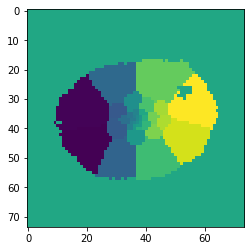

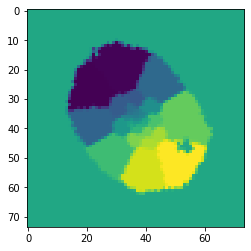

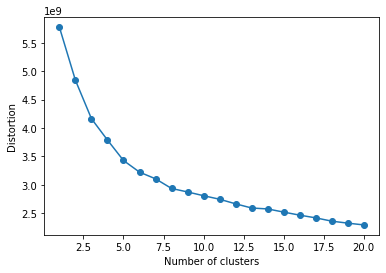

In [33]:
plt.clf()
plt.imshow(np.reshape(map_array_ml_rot_inv[0], (size, size)))
plt.show()

plt.imshow(np.reshape(map_array_ml_rot_inv[1], (size, size)))
plt.show()

# But how many clusters do you select?
# calculate distortion for a range of number of cluster
distortions = []
for i in range(1, 21):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(map_array_ml_rot_inv)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 21), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()
# This plot decreases quite smoothely, which makes me highly suspicious of the process

In [1]:
# Okay so maybe k-means is too simplistic, try 
# Gaussian mixture models
from sklearn.mixture import GaussianMixture as GMM
n_components = np.arange(1, 11)
models = [GMM(n, covariance_type='full', random_state=0).fit(map_array_ml)
          for n in n_components]

plt.plot(n_components, [m.bic(map_array_ml_rot_inv) for m in models], label='BIC')
plt.plot(n_components, [m.aic(map_array_ml_rot_inv) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

NameError: name 'np' is not defined

(480, 5476) (480, 199)


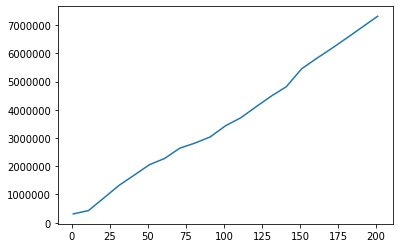

In [48]:
from sklearn.decomposition import PCA
pca = PCA(0.99, whiten=True)
data = pca.fit_transform(map_array_ml_rot_inv)
print(map_array_ml_rot_inv.shape,data.shape)
n_components = np.arange(1, 210, 10)
models = [GMM(n, covariance_type='full', random_state=0)
          for n in n_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics);

In [55]:
gmm = GMM(110, covariance_type='full', random_state=0)
gmm.fit(data)
print(gmm.converged_)

data_new = gmm.sample(100)#, random_state=0)
maps_new = pca.inverse_transform(data_new)
plot_digits(maps_new)

True


ValueError: could not broadcast input array from shape (100,199) into shape (100)

True
False
False


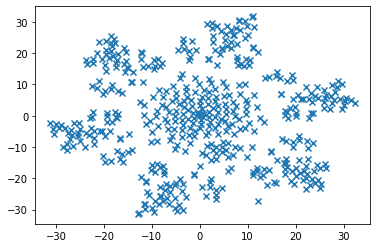

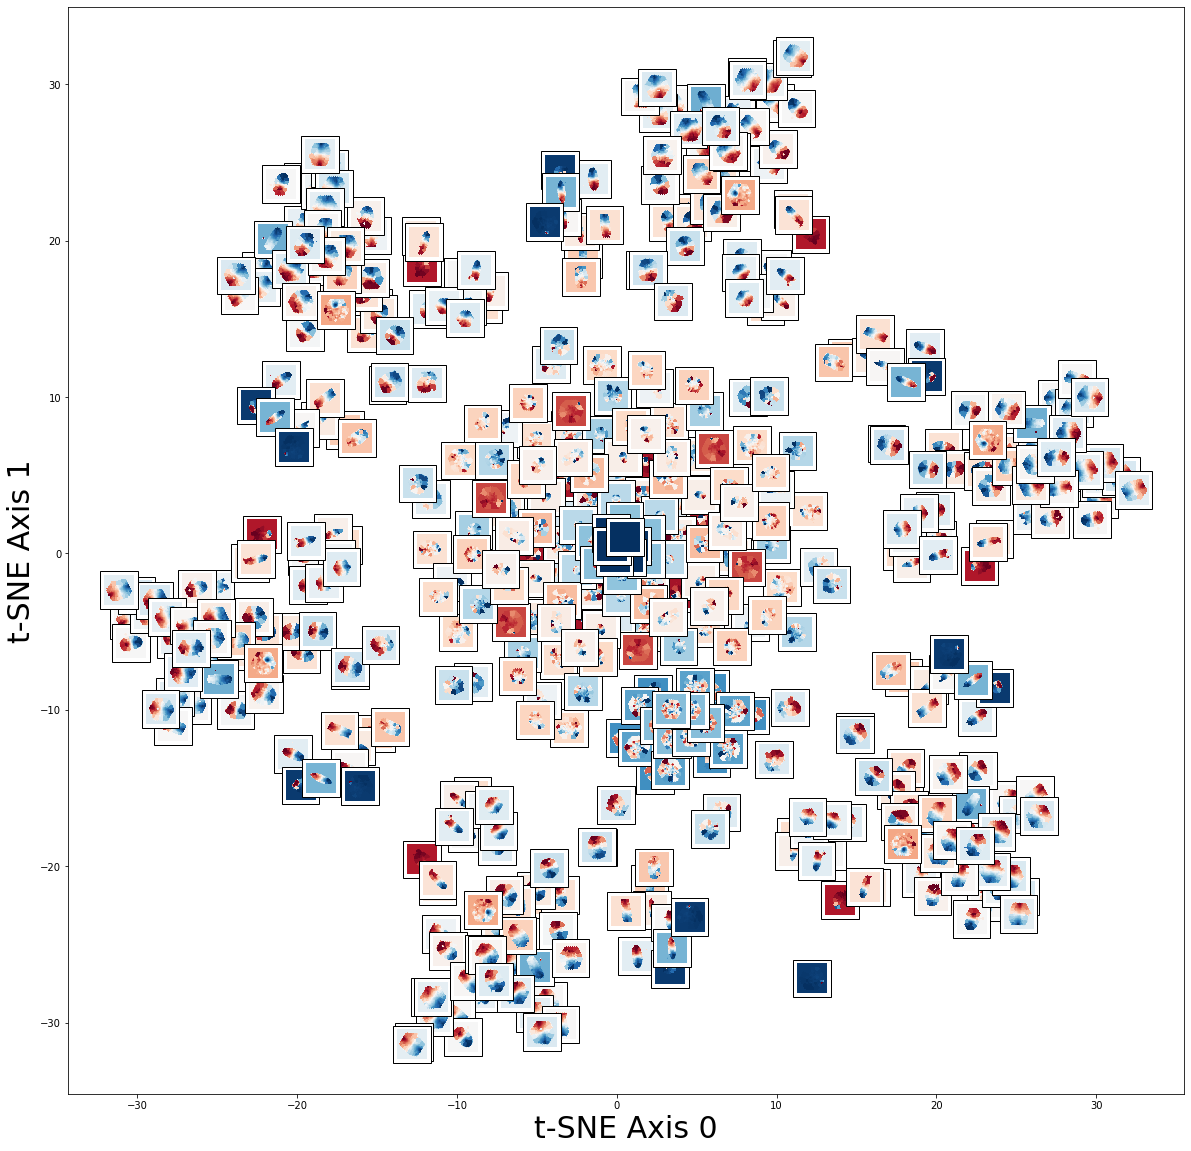

In [37]:

# Try out the same thing but pre-process with t-SNE
from sklearn.manifold import TSNE
#T-distributed Stochastic Neighbor Embedding (t-SNE)

# Project the data: this step will take several seconds
tsne = TSNE(n_components=2, init='random', random_state=0, method='exact')
# t-SNE collapses everything down into 2 dimensions, which don't really have a meaning
# but it is an interesting way to visualize the data

'''masked_map_array_ml = np.ma.masked_where(np.isnan(map_array_ml), map_array_ml)
masked_map_array_ml = np.ma.masked_where(np.isinf(masked_map_array_ml), masked_map_array_ml)
for i in range(np.shape(masked_map_array_ml)[0]):
    
    for j in range(len(masked_map_array_ml[i])):
        if np.isnan(masked_map_array_ml[i][j]) or np.isinf(masked_map_array_ml[i][j]):
            print(masked_map_array_ml[i][j])'''

print(np.isfinite(map_array_ml_rot_inv).all()) # True 
print(np.isnan(map_array_ml_rot_inv).all()) # False
print(np.isinf(map_array_ml_rot_inv).all()) # False
            
map_array_ml_proj = tsne.fit_transform(map_array_ml_rot_inv)

plt.clf()
plt.scatter(map_array_ml_proj[:,0], map_array_ml_proj[:,1], marker='x')
plt.show()

# This code is from Becky Smethurst (thanks!!)

from matplotlib.offsetbox import OffsetImage, AnnotationBbox 
from matplotlib import pyplot as plt

def imscatter(x, y, images, ax=None, zoom=0.1):     
        if ax is None:         
                ax = plt.gca()           
        x, y = np.atleast_1d(x, y)     
        artists = []     
        for x0, y0, image0 in zip(x, y, images):
                ima = image0
                im = OffsetImage(ima, zoom=zoom, cmap='RdBu_r')   
                ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=True)         
                artists.append(ax.add_artist(ab))     
        ax.update_datalim(np.column_stack([x, y]))     
        ax.autoscale()     
        return artists
#np.reshape(map_array_ml[j,:],(shape,shape))
twod = np.reshape(map_array_ml_rot_inv, (np.shape(map_array_ml_rot_inv)[0],size, size))

fig = plt.figure(figsize=(20,20))
ax1 = plt.gca()
imscatter(map_array_ml_proj[:,0], map_array_ml_proj[:,1], np.ma.masked_where(twod==0, twod), ax=ax1, zoom=0.4)
ax1.set_xlabel('t-SNE Axis 0', size=30)
ax1.set_ylabel('t-SNE Axis 1', size=30)
plt.savefig('tSNE.png', dpi=1000)

74.0


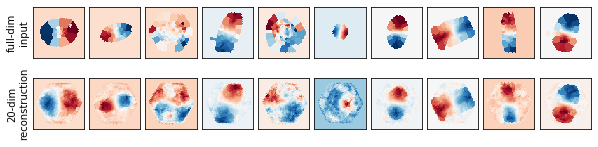

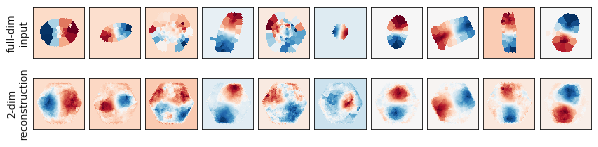

In [32]:
# Try running a PCA on the images first
from sklearn.decomposition import PCA

print(np.sqrt(np.shape(map_array_ml)[1]))
pca = PCA(20)
pca.fit(map_array_ml)
components = pca.transform(map_array_ml)
projected = pca.inverse_transform(components)
# Plot the results
fig, ax = plt.subplots(2, 10, figsize=(10, 2.5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    ax[0, i].imshow(map_array_ml[i].reshape(74,74), cmap='RdBu_r')
    ax[1, i].imshow(projected[i].reshape(74,74), cmap='RdBu_r')
    
ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('20-dim\nreconstruction');


pca = PCA(15)
pca.fit(map_array_ml)
components = pca.transform(map_array_ml)
projected = pca.inverse_transform(components)
# Plot the results
fig, ax = plt.subplots(2, 10, figsize=(10, 2.5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    ax[0, i].imshow(map_array_ml[i].reshape(74,74), cmap='RdBu_r')
    ax[1, i].imshow(projected[i].reshape(74,74), cmap='RdBu_r')
    
ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('2-dim\nreconstruction');

(80, 5476) (80, 5476) (80, 2)


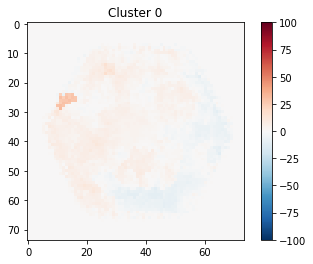

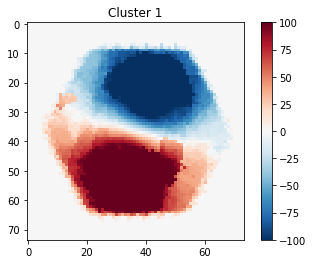

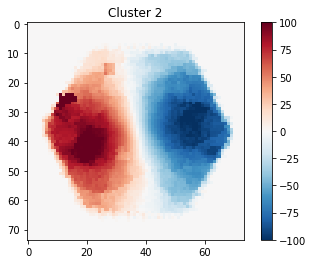

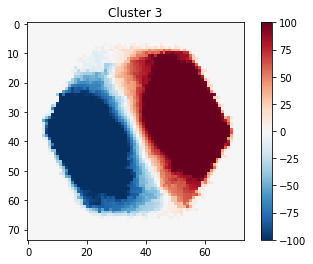

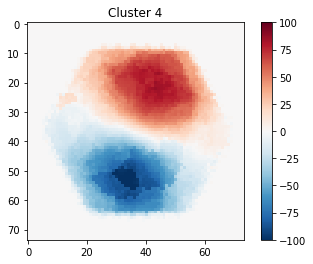

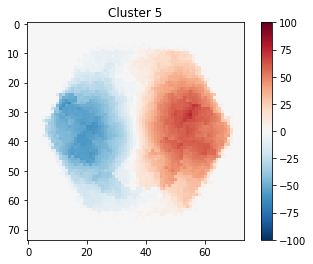

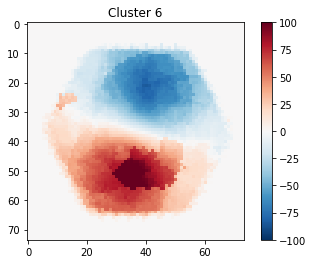

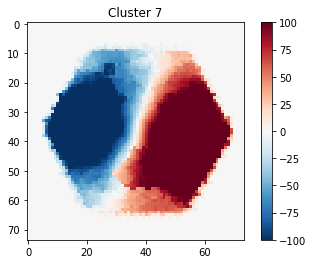

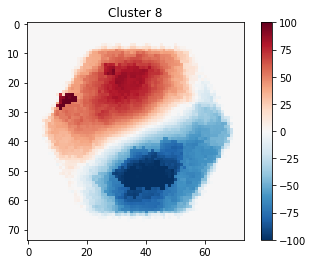

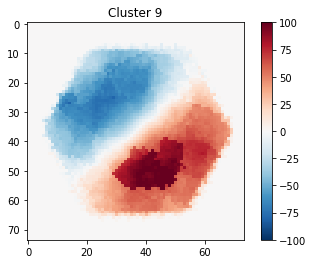

[5 0 0 4 0 0 4 2 4 1 5 1 6 2 5 0 4 6 6 0 5 0 2 8 0 1 0 0 4 4 0 5 1 5 0 5 9
 0 0 8 4 2 0 4 8 2 5 0 0 3 5 0 8 9 9 0 7 6 6 8 5 5 0 0 1 2 5 4 2 0 2 0 4 0
 0 4 6 5 0 8]


<Figure size 432x288 with 0 Axes>

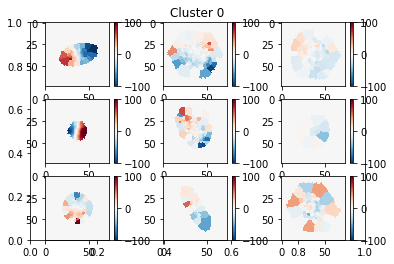

<Figure size 432x288 with 0 Axes>

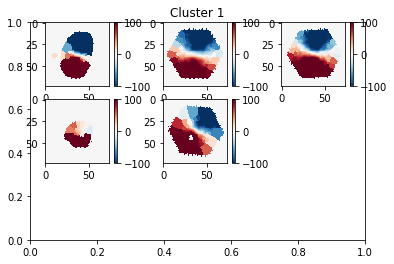

<Figure size 432x288 with 0 Axes>

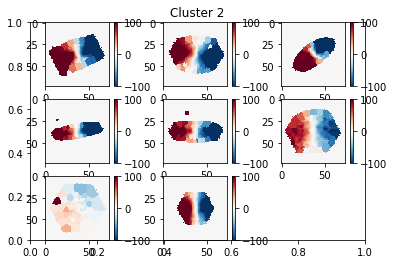

<Figure size 432x288 with 0 Axes>

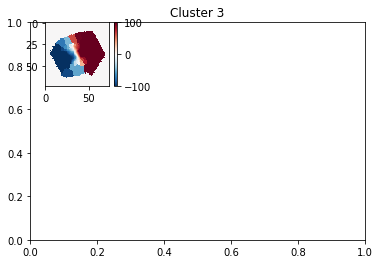

<Figure size 432x288 with 0 Axes>

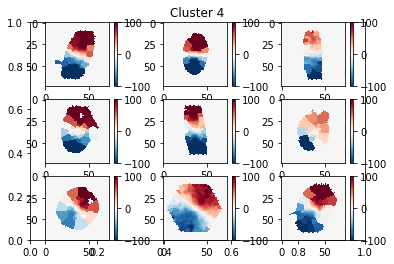

<Figure size 432x288 with 0 Axes>

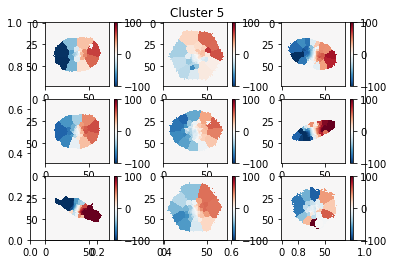

<Figure size 432x288 with 0 Axes>

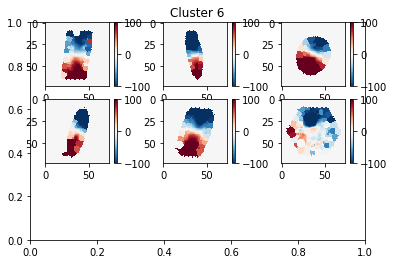

<Figure size 432x288 with 0 Axes>

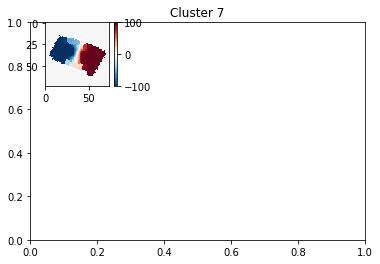

<Figure size 432x288 with 0 Axes>

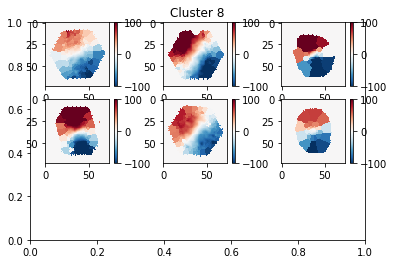

<Figure size 432x288 with 0 Axes>

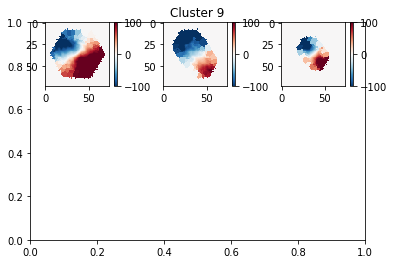

In [30]:
# Try k-means - this tutorial does the digits - https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html
print(np.shape(map_array_ml), np.shape(projected), np.shape(components))

from sklearn.cluster import KMeans

# the data needs to be in shape (n_things, x*y), where x and y are the dimensions of each map
# I'm really not sure what to do if the dimensions are different
nclusters=10

kmeans = KMeans(n_clusters=nclusters, random_state=0)
clusters = kmeans.fit_predict(projected)
# the center of the cluster is the arithmetic mean of all the 
# points belonging to the cluster, each point in a cluster is closer
# to that cluster center than to any other cluster centers

# Visualizing what the heck this actually looks like

centers = kmeans.cluster_centers_.reshape(nclusters, shape, shape)


for j in range(nclusters):
    plt.clf()
    plt.imshow(centers[j], cmap='RdBu_r', vmin=-100, vmax=100)
    plt.colorbar()
    plt.title('Cluster '+str(j))
    plt.show()



# My next question is is there a way to visualize multiple maps within each class
print(clusters)
# these are the cluster IDs of each galaxy
cluster={}
#cluster_name=[]
for n in range(nclusters):
    
    cluster[n]=[]
    for j in range(data_length):
        if clusters[j]==n:
            cluster[n].append(np.reshape(map_array_ml[j,:],(shape,shape)))
    #cluster_name.append(str(cluster[n]))
nclusters_list = np.arange(0,nclusters)



# Plot multiple examples of each class
for i in range(nclusters):
    plt.clf()
    fig=plt.figure()
    #fig.subplots_adjust(hspace = .5, wspace=.001)
    plt.title('Cluster '+str(i))
    
    if np.shape(cluster[i])[0] < 9:
        for j in range(np.shape(cluster[i])[0]):
            ax = fig.add_subplot(3,3,j+1)
            im = ax.imshow(cluster[i][j], cmap='RdBu_r', vmin=-100, vmax=100)
            plt.colorbar(im)
        plt.show()
    else:
        for j in range(9):
            ax = fig.add_subplot(3,3,j+1)
            im = ax.imshow(cluster[i][j], cmap='RdBu_r', vmin=-100, vmax=100)
            plt.colorbar(im)
        plt.show()
# Interestingly, without any pre-processing, one thing k-means sorts by is the direction of the velocity gradient.
# This applies to cluster 1, 5, 6, and 8, which are all oriented differently but basically the same type of map.
# k-menas also sorts by different sorts of irregularities.
# one option is to standardize the maps and look at the outcome again (in the next cell)



In [ ]:
# This looks like it is still preserving the dipole so I'll need a way of doing this better.

In [37]:
# Try k-means - this tutorial does the digits - https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html


from sklearn.cluster import KMeans
print(np.shape(map_array_ml))

# the data needs to be in shape (n_things, x*y), where x and y are the dimensions of each map
# I'm really not sure what to do if the dimensions are different
nclusters=10

kmeans = KMeans(n_clusters=nclusters, random_state=0)
clusters = kmeans.fit_predict(map_array_ml)
# the center of the cluster is the arithmetic mean of all the 
# points belonging to the cluster, each point in a cluster is closer
# to that cluster center than to any other cluster centers


/Users/beckynevin/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/beckynevin/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/beckynevin/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


(215, 5476)


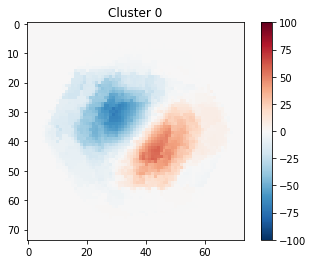

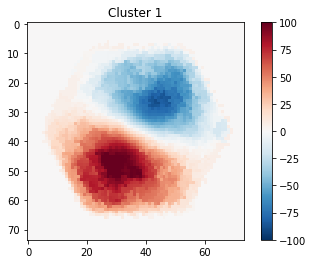

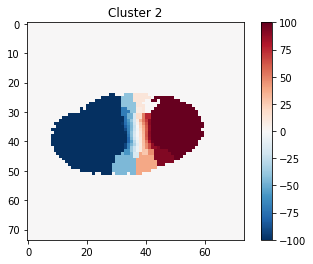

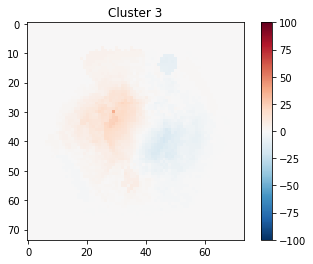

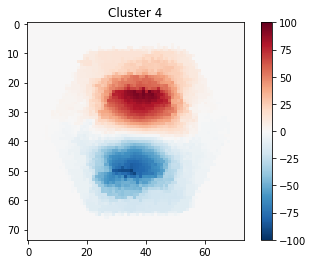

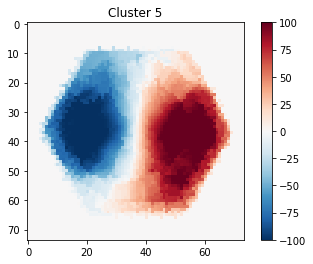

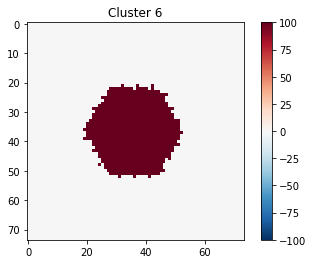

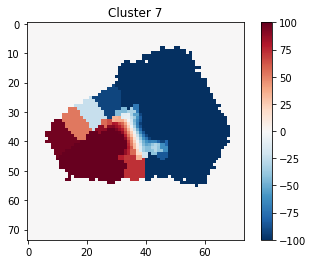

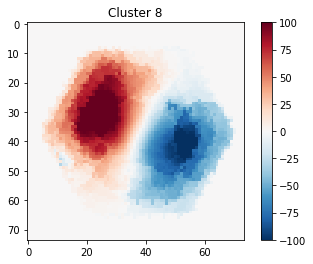

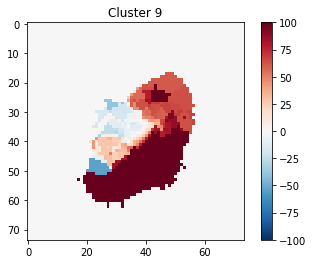

[0 1 4 4 3 0 9 3 8 0 5 0 3 0 8 0 8 3 4 3 4 5 1 0 3 1 1 8 3 0 3 1 3 3 3 0 3
 5 5 3 4 3 5 3 3 5 0 8 3 0 3 3 3 3 0 4 9 1 0 3 3 3 4 4 0 1 3 1 3 4 3 3 0 3
 0 3 9 8 8 3 0 4 3 3 6 8 0 8 3 4 4 0 0 4 5 3 8 1 4 3 0 4 0 3 3 3 1 3 3 3 0
 0 1 3 3 5 3 3 4 3 5 3 0 3 3 3 3 2 3 1 4 0 3 3 3 1 4 8 5 0 3 3 3 3 0 3 8 0
 3 3 0 3 0 4 3 8 8 4 0 0 3 8 3 3 3 4 0 3 3 3 1 5 3 1 0 1 3 0 0 7 0 3 1 3 3
 3 3 3 3 0 1 4 3 4 0 4 3 5 3 1 0 4 3 3 8 4 4 3 3 1 3 4 3 3 4]


<Figure size 432x288 with 0 Axes>

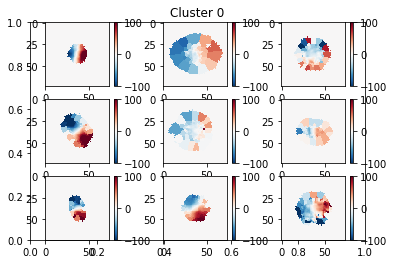

<Figure size 432x288 with 0 Axes>

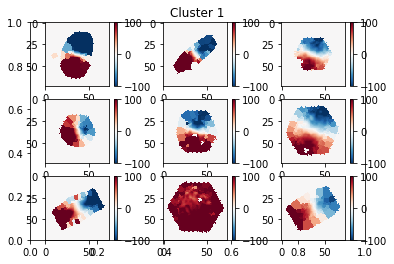

<Figure size 432x288 with 0 Axes>

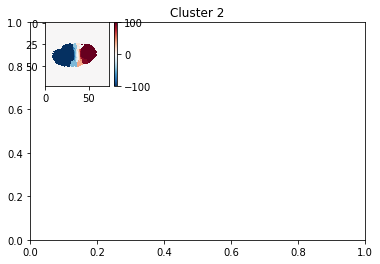

<Figure size 432x288 with 0 Axes>

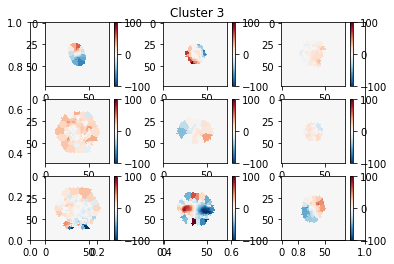

<Figure size 432x288 with 0 Axes>

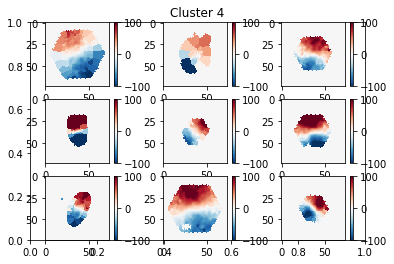

<Figure size 432x288 with 0 Axes>

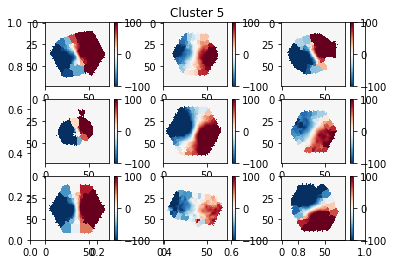

<Figure size 432x288 with 0 Axes>

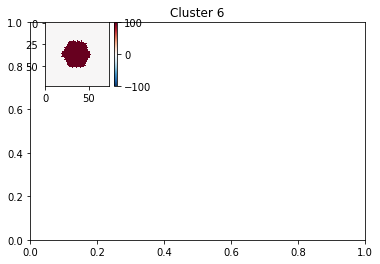

<Figure size 432x288 with 0 Axes>

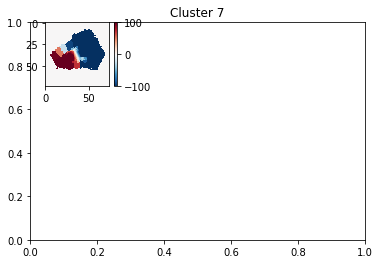

<Figure size 432x288 with 0 Axes>

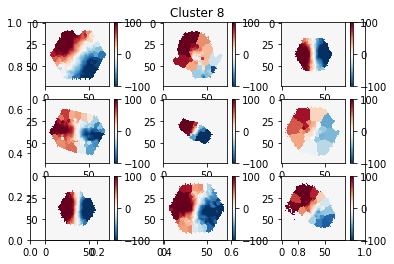

<Figure size 432x288 with 0 Axes>

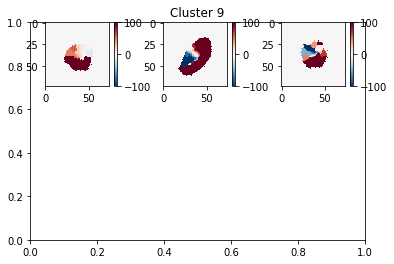

In [38]:
# Visualizing what the heck this actually looks like

centers = kmeans.cluster_centers_.reshape(nclusters, shape, shape)


for j in range(nclusters):
    plt.clf()
    plt.imshow(centers[j], cmap='RdBu_r', vmin=-100, vmax=100)
    plt.colorbar()
    plt.title('Cluster '+str(j))
    plt.show()



# My next question is is there a way to visualize multiple maps within each class
print(clusters)
# these are the cluster IDs of each galaxy
cluster={}
#cluster_name=[]
for n in range(nclusters):
    
    cluster[n]=[]
    for j in range(data_length):
        if clusters[j]==n:
            cluster[n].append(np.reshape(map_array_ml[j,:],(shape,shape)))
    #cluster_name.append(str(cluster[n]))
nclusters_list = np.arange(0,nclusters)



# Plot multiple examples of each class
for i in range(nclusters):
    plt.clf()
    fig=plt.figure()
    #fig.subplots_adjust(hspace = .5, wspace=.001)
    plt.title('Cluster '+str(i))
    
    if np.shape(cluster[i])[0] < 9:
        for j in range(np.shape(cluster[i])[0]):
            ax = fig.add_subplot(3,3,j+1)
            im = ax.imshow(cluster[i][j], cmap='RdBu_r', vmin=-100, vmax=100)
            plt.colorbar(im)
        plt.show()
    else:
        for j in range(9):
            ax = fig.add_subplot(3,3,j+1)
            im = ax.imshow(cluster[i][j], cmap='RdBu_r', vmin=-100, vmax=100)
            plt.colorbar(im)
        plt.show()
# Interestingly, without any pre-processing, one thing k-means sorts by is the direction of the velocity gradient.
# This applies to cluster 1, 5, 6, and 8, which are all oriented differently but basically the same type of map.
# k-menas also sorts by different sorts of irregularities.
# one option is to standardize the maps and look at the outcome again (in the next cell)


In [ ]:
# An interesting thing you may notice is that the clusters seem to rely 
# heavily on the direction of the velocity field.
# This seems to be the primary effect.

# To determine if the clustering is being affected by the size of the IFU
# it is important to filter out the directionality first

[9 0 6 0 6 9 6 6 8 6 1 6 2 6 2 0 4 1 0 1 2 6 6 2 9 6 6 0 7 2 8 6 6 0 6 2 2
 8 1 1 3 2 6 6 8 6 1 8 0 6 6 6 6 2 9 6 1 8 6 2 6 9 6 8 6 8 6 6 2 8 8 1 6 6
 8 2 6 2 1 6 8 6 6 9 6 6 8 6 2 6 9 6 9 6 6 1 1 2 2 6 2 8 9 2 1 6 8 6 1 9 6
 6 6 6 9 9 6 2 6 6 6 6 6 2 9 6 6 6 6 0 9 2 9 6 8 6 6 9 0 6 2 6 2 9 9 1 0 6
 0 2 6 6 5 1 6 6 6 6 0]


<Figure size 432x288 with 0 Axes>

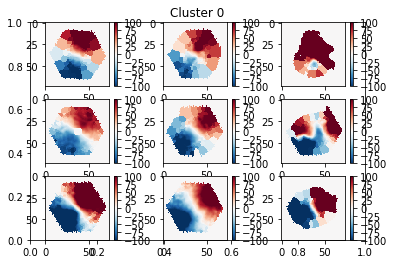

<Figure size 432x288 with 0 Axes>

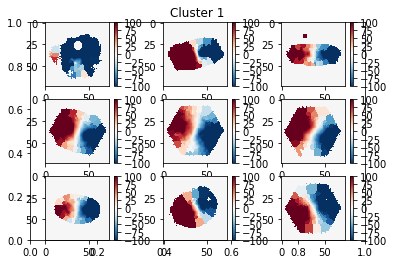

<Figure size 432x288 with 0 Axes>

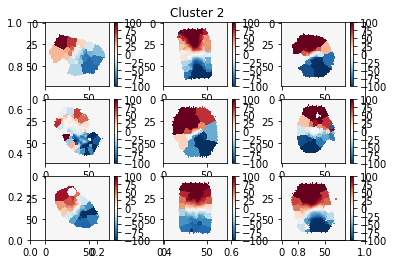

<Figure size 432x288 with 0 Axes>

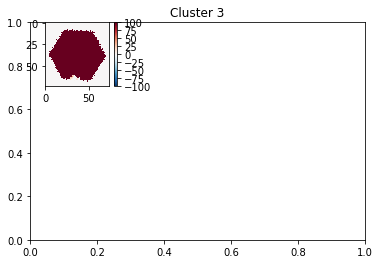

<Figure size 432x288 with 0 Axes>

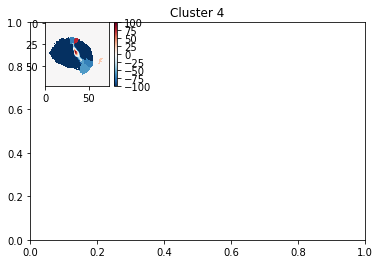

<Figure size 432x288 with 0 Axes>

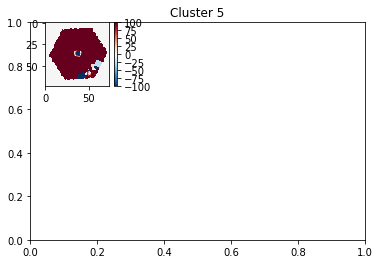

<Figure size 432x288 with 0 Axes>

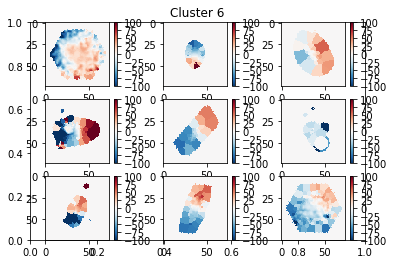

<Figure size 432x288 with 0 Axes>

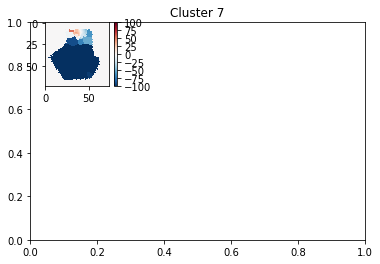

<Figure size 432x288 with 0 Axes>

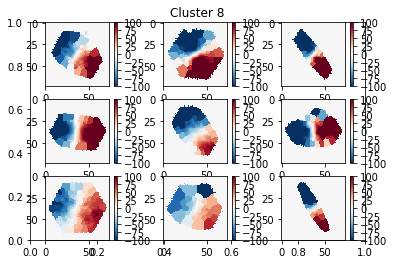

<Figure size 432x288 with 0 Axes>

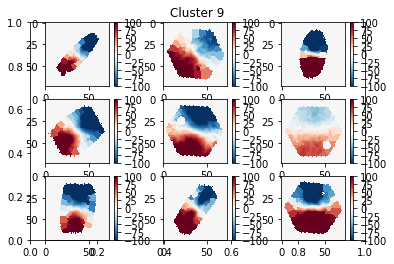

In [11]:
# Trying to first standardize the data and re-k-means it:
# It is possible to do this using an sklearn pipeline

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

scaler = StandardScaler()

nclusters=10
kmeans = KMeans(n_clusters=nclusters, random_state=0)

pipeline = make_pipeline(scaler, kmeans)



#clusters = pipeline.fit(map_array_ml)

clusters = pipeline.fit_predict(map_array_ml)
# the center of the cluster is the arithmetic mean of all the 
# points belonging to the cluster, each point in a cluster is closer
# to that cluster center than to any other cluster centers



# My next question is is there a way to visualize multiple maps within each class
print(clusters)
# these are the cluster IDs of each galaxy
cluster={}
#cluster_name=[]
for n in range(nclusters):
    
    cluster[n]=[]
    for j in range(data_length):
        if clusters[j]==n:
            cluster[n].append(np.reshape(map_array_ml[j,:],(shape,shape)))
    #cluster_name.append(str(cluster[n]))
nclusters_list = np.arange(0,nclusters)



# Plot multiple examples of each class
for i in range(nclusters):
    plt.clf()
    fig=plt.figure()
    #fig.subplots_adjust(hspace = .5, wspace=.001)
    plt.title('Cluster '+str(i))
    
    if np.shape(cluster[i])[0] < 9:
        for j in range(np.shape(cluster[i])[0]):
            ax = fig.add_subplot(3,3,j+1)
            im = ax.imshow(cluster[i][j], cmap='RdBu_r', vmin=-100, vmax=100)
            plt.colorbar(im)
        plt.show()
    else:
        for j in range(9):
            ax = fig.add_subplot(3,3,j+1)
            im = ax.imshow(cluster[i][j], cmap='RdBu_r', vmin=-100, vmax=100)
            plt.colorbar(im)
        plt.show()

True
False
False


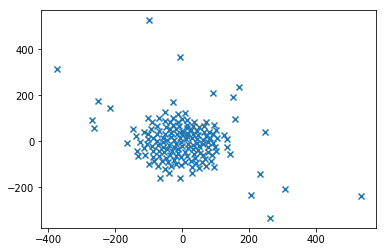

In [14]:
# Try out the same thing but pre-process with t-SNE
from sklearn.manifold import TSNE
#T-distributed Stochastic Neighbor Embedding (t-SNE)

# Project the data: this step will take several seconds
tsne = TSNE(n_components=2, init='random', random_state=0, method='exact')
# t-SNE collapses everything down into 2 dimensions, which don't really have a meaning
# but it is an interesting way to visualize the data

'''masked_map_array_ml = np.ma.masked_where(np.isnan(map_array_ml), map_array_ml)
masked_map_array_ml = np.ma.masked_where(np.isinf(masked_map_array_ml), masked_map_array_ml)
for i in range(np.shape(masked_map_array_ml)[0]):
    
    for j in range(len(masked_map_array_ml[i])):
        if np.isnan(masked_map_array_ml[i][j]) or np.isinf(masked_map_array_ml[i][j]):
            print(masked_map_array_ml[i][j])'''

print(np.isfinite(map_array_ml).all()) # True 
print(np.isnan(map_array_ml).all()) # False
print(np.isinf(map_array_ml).all()) # False
            
map_array_ml_proj = tsne.fit_transform(map_array_ml)

plt.clf()
plt.scatter(map_array_ml_proj[:,0], map_array_ml_proj[:,1], marker='x')
plt.show()

# I am not sure if this is going to help at this point, unless I can plot the individual points
# as velocity maps...



[-- -- -- ... -- -- --]


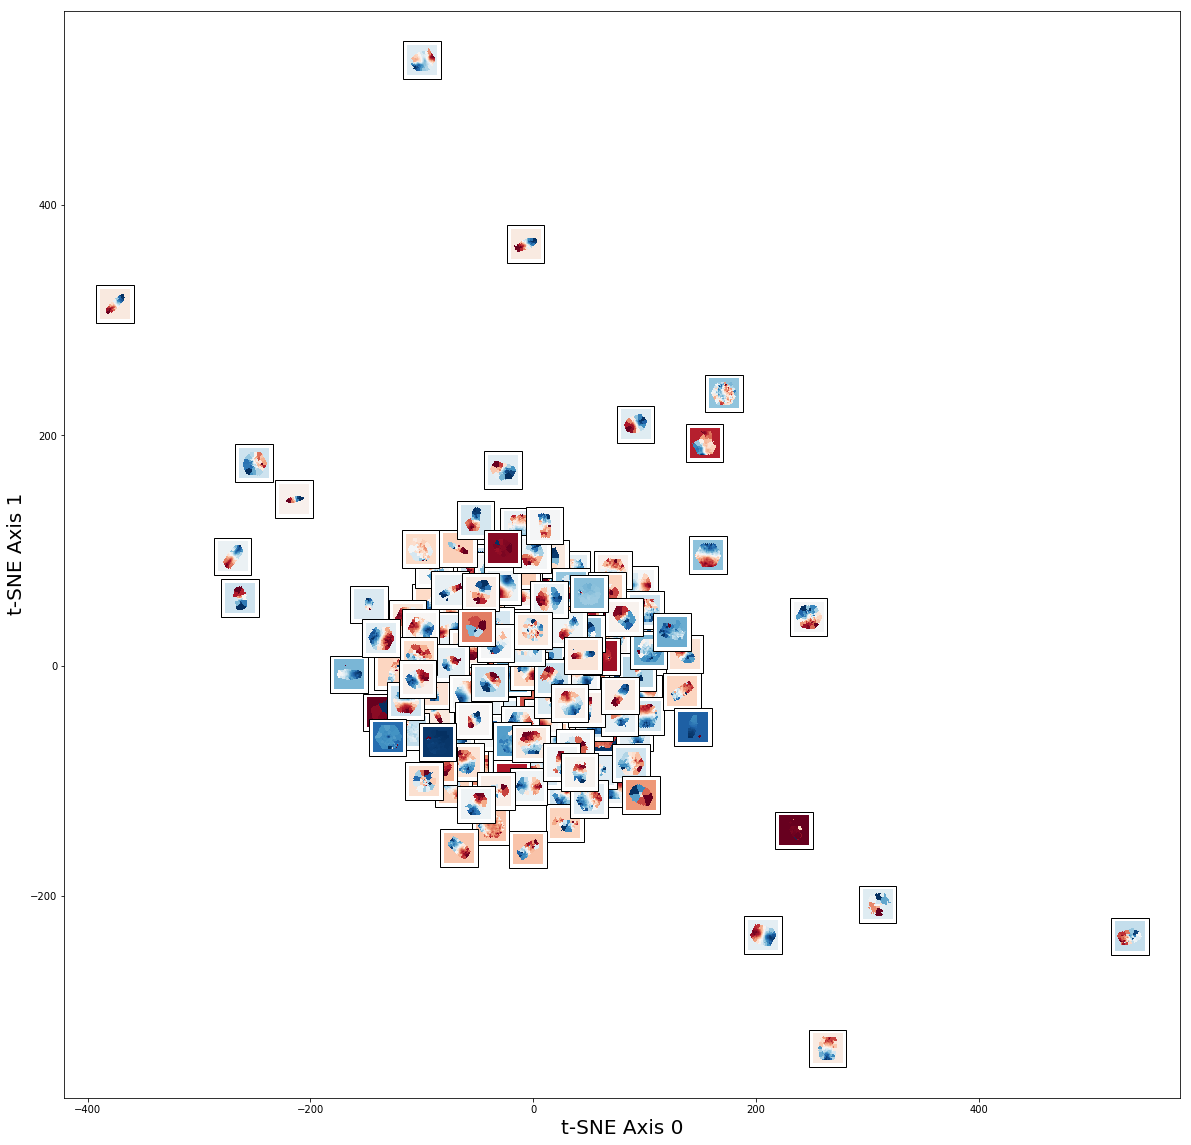

In [37]:
# This code is from Becky Smethurst (thanks!!)

from matplotlib.offsetbox import OffsetImage, AnnotationBbox 
from matplotlib import pyplot as plt

def imscatter(x, y, images, ax=None, zoom=0.1):     
        if ax is None:         
                ax = plt.gca()           
        x, y = np.atleast_1d(x, y)     
        artists = []     
        for x0, y0, image0 in zip(x, y, images):
                ima = image0
                im = OffsetImage(ima, zoom=zoom, cmap='RdBu_r')   
                ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=True)         
                artists.append(ax.add_artist(ab))     
        ax.update_datalim(np.column_stack([x, y]))     
        ax.autoscale()     
        return artists
#np.reshape(map_array_ml[j,:],(shape,shape))
map_array_ml_mask = np.ma.masked_where(map_array_ml==0., map_array_ml)
print(map_array_ml_mask[0])
twod = np.reshape(map_array_ml_mask, (np.shape(map_array_ml)[0],shape,shape))

fig = plt.figure(figsize=(20,20))
ax1 = plt.gca()
imscatter(map_array_ml_proj[:,0], map_array_ml_proj[:,1], np.ma.masked_where(twod==0, twod), ax=ax1, zoom=0.4)
ax1.set_xlabel('t-SNE Axis 0', size=20)
ax1.set_ylabel('t-SNE Axis 1', size=20)
plt.show()

(10, 2)


TypeError: Invalid dimensions for image data

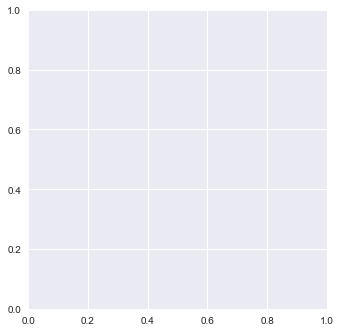

In [74]:
nclusters=10

kmeans = KMeans(n_clusters=nclusters, random_state=0)
clusters = kmeans.fit_predict(map_array_ml_proj)
# the center of the cluster is the arithmetic mean of all the 
# points belonging to the cluster, each point in a cluster is closer
# to that cluster center than to any other cluster centers
print(kmeans.cluster_centers_.shape)

# Visualizing what the heck this actually looks like



centers = kmeans.cluster_centers_#.reshape(nclusters, shape, shape)


for j in range(nclusters):
    plt.clf()
    plt.imshow(centers[j], cmap='RdBu_r', vmin=-100, vmax=100)
    plt.colorbar()
    plt.title('Cluster '+str(j))
    plt.show()



# My next question is is there a way to visualize multiple maps within each class
print(clusters)
# these are the cluster IDs of each galaxy
cluster={}
#cluster_name=[]
for n in range(nclusters):
    
    cluster[n]=[]
    for j in range(data_length):
        if clusters[j]==n:
            cluster[n].append(np.reshape(map_array_ml[j,:],(shape,shape)))
    #cluster_name.append(str(cluster[n]))
nclusters_list = np.arange(0,nclusters)



# Plot multiple examples of each class
for i in range(nclusters):
    plt.clf()
    fig=plt.figure()
    #fig.subplots_adjust(hspace = .5, wspace=.001)
    plt.title('Cluster '+str(i))
    
    if np.shape(cluster[i])[0] < 9:
        for j in range(np.shape(cluster[i])[0]):
            ax = fig.add_subplot(3,3,j+1)
            im = ax.imshow(cluster[i][j], cmap='RdBu_r', vmin=-100, vmax=100)
            plt.colorbar(im)
        plt.show()
    else:
        for j in range(9):
            ax = fig.add_subplot(3,3,j+1)
            im = ax.imshow(cluster[i][j], cmap='RdBu_r', vmin=-100, vmax=100)
            plt.colorbar(im)
        plt.show()



In [ ]:
import time as time
from sklearn.feature_extraction.image import grid_to_graph
from sklearn.cluster import AgglomerativeClustering
###############################################################################
# Define the structure A of the data. Pixels connected to their neighbors.
connectivity = grid_to_graph(*map_array_ml.shape)

###############################################################################
# Compute clustering
print("Compute structured hierarchical clustering...")
st = time.time()
n_clusters = 15  # number of regions
ward = AgglomerativeClustering(n_clusters=n_clusters,
        linkage='ward', connectivity=connectivity).fit(map_array_ml)

(1797, 64)
[[ 0.  0.  5. 13.  9.  1.  0.  0.]
 [ 0.  0. 13. 15. 10. 15.  5.  0.]
 [ 0.  3. 15.  2.  0. 11.  8.  0.]
 [ 0.  4. 12.  0.  0.  8.  8.  0.]
 [ 0.  5.  8.  0.  0.  9.  8.  0.]
 [ 0.  4. 11.  0.  1. 12.  7.  0.]
 [ 0.  2. 14.  5. 10. 12.  0.  0.]
 [ 0.  0.  6. 13. 10.  0.  0.  0.]]


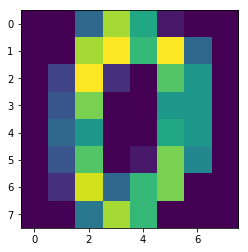

4 <class 'int'>
(4, 64)


TypeError: only size-1 arrays can be converted to Python scalars

In [40]:
#trying out k-means on the digits dataset
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
digits = load_digits()
print(digits.data.shape)
print(np.reshape(digits.data[0],(8,8)))
plt.imshow(np.reshape(digits.data[0],(8,8)))
plt.show()


clusters=4
print(clusters, type(int(clusters/2)))
kmeans = KMeans(n_clusters=clusters, random_state=0)
clusters = kmeans.fit_predict(digits.data)
print(kmeans.cluster_centers_.shape)

fig, ax = plt.subplots(2, int(clusters/2), figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(clusters, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)
plt.show()

In [41]:
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]
    
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)


0.3639398998330551

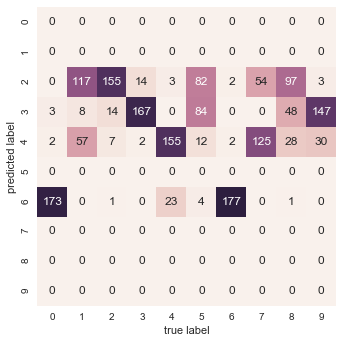

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set() 
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [43]:
from sklearn.manifold import TSNE

# Project the data: this step will take several seconds
tsne = TSNE(n_components=2, init='random', random_state=0)
digits_proj = tsne.fit_transform(digits.data)

# Compute the clusters
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits_proj)

# Permute the labels
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

# Compute the accuracy
accuracy_score(digits.target, labels)

0.11129660545353366

In [35]:
# How to do batch downloading

import os
print(os.environ['SAS_BASE_DIR'])

print(os.getcwd())

STOP
from marvin.utils.general import get_drpall_table
data = get_drpall_table()

import numpy as np
primary        = data['mngtarg1'] & 2**10
secondary      = data['mngtarg1'] & 2**11
color_enhanced = data['mngtarg1'] & 2**12

main_sample = np.logical_or.reduce((primary, secondary, color_enhanced))

plateifus = data['plateifu'][main_sample]
print(plateifus)
STOP

from marvin.utils.general.general import downloadList
downloadList(plateifus, dltype='map')

/Volumes/My\ Book/sas
/Users/beckynevin/Documents/Backup_My_Book/My_Passport_backup/Kinematic_ML


NameError: name 'STOP' is not defined

In [36]:
from marvin.tools import Cube

cc = Cube(plateifu='9002-12701', mode='remote')

cc

cc.download()

There is no file with filetype='mangacube' to access in the tree module loaded


AccessError: No files to download.